# Определение стоимости автомобилей / Car price prediction

По историческим данным автомобилей (технические характеристики, комплектации и цены) обучить модель машинного обучения для предсказания рыночной стоимости автомобиля. Данная модель будет использоваться заказчиком в разрабатываемом приложении для привлечения клиентов.

Заказчику важны:

- качество предсказания,
- скорость предсказания,
- время обучения.


Based on the historical data of cars (technical specifications, equipment and prices), train a machine learning model to predict the market value of a car. This model will be used by the customer in the application being developed to attract customers.

Important for client:

- the quality of the prediction,
- prediction speed,
- training time.

## Подготовка данных / Data preparation

In [ ]:
# загрузим необходимые библиотеки и/или их элементы

import warnings
warnings.filterwarnings('once')
import pandas as pd
import numpy as np
#import dtale as dt
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
#from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from lightgbm import LGBMRegressor
pd.options.display.float_format = '{:,.2f}'.format
import time
#from hpsklearn import HyperoptEstimator, random_forest_regressor

%matplotlib inline

In [5]:
# считаем данные / read the data
try:
    cars = pd.read_csv('/home/uladzislau/Documents/Yandex DS/Projects/Numerical Analysis/autos.csv')
except:
    cars = pd.read_csv('/datasets/autos.csv')

In [ ]:
dt.show(cars)

В данных 354369 наблюдений и 16 признаков.

- Колонка **Price** - целевой признак, пропусков нет. Есть аномальные значения цены (0, 1, 2, .....).


- Колонка **VehicleType** - обозначает тип кузова машины. Распределение переменной следующее: sedan (91457), small (79831), wagon (65166), bus (28775), convertible (20203), coupe (16163), suv (11996), other (3288). Колонка имеет 10.6% пропусков.


- Колонка **RegistrationYear** - год регистрации автомобиля. Пропусков нет. Есть аномальные значения (1111, 3000, 5000, 6000, 9000, все значения больше 2016). Может косвенно сказать о возрасте автомобиля.


- Колонка **Gearbox** - тип коробки передач. Содержит 5.6% пропусков. Распределение типов коробок такое: manual (268251), auto (66285).


- Колонка **Power** - отражает лошадиные силы автомобиля. Пропусков нет. Есть аномальные значения (0, 20000). Самое распространенное значение - 0 (40225 наблюдений).


- Колонка **Model** - модель автомобиля. 5.6% пропусков, 250 уникальных значений. Самой распространенной моделью является Golf (Volkswagen) - 29232 наблюдения. Топ-10 выглядт следующим образом: golf (29232), other (24421), 3er (19761), polo (13066), corsa (12570), astra (10809), passat (10146), a4 (9900), c_klasse (8312), 5er (7868).


- Колонка **Kilometer** - пробег автомобиля в км. Пропусков нет. В колонке 13 уникальных значений (скорее всего, люди округляют пробег до целого числа). Распределение пробега выглядит следующим образом: 150000 (238209), 125000 (36454), 100000 (14882), 90000 (11567), 80000 (10047), 70000 (8593), 60000 (7444), 5000 (6397), 50000 (6232), 40000 (4911), 30000 (4436), 20000 (3975), 10000 (1222). Большинство автомобилей имеют пробег 150000 км. Только 25% машин имеют пробег менее 125000 км.


- Колонка **RegistrationMonth** - месяц регистрации автомобиля. Пропусков нет. Есть аномальное значение 0, которое имеют большинство наблюдений (37352). В отличии от года регистрации не выглядит значимым для модели.


- Колонка **FuelType** - тип топлива. 9.3% пропусков. Распределение признака такое - petrol (216352), gasoline (98720), lpg (5310), cng (565), hybrid (233), other (204), electric (90). LPG - сжиженный углеводородный газ, CNG - компримированный (сжатый) природный газ.


- Колонка **Brand** - бренд автомобиля. В таблице присутствуют 40 брендов. Пропусков нет. Топ-10 брендов: volkswagen (77013), opel (39931), bmw (36914), mercedes_benz (32046), audi (29456), ford (25179), renault (17927), peugeot (10998), fiat (9643), seat (6907).


- Колонка **NotRepaired** - была ли машина в ремонте. Колонка имеет 20.1% пропусков. Большинство машин не были в ремонте (247161).


- Колонка **NumberOfPictures** - количество фотографий автомобиля в объявлении. Все машины имеют 0 фотографий.


- Колонка **PostalCode** - почтовый код владельца объявления. Пропусков нет. Как таковая не имеет ценности для обучения моделей, но может быть использована для определения страны продажи автомобиля. Такой признак может быть информативен для модели.

Колонки **DateCrawled**, **DateCreated**, и **LastSeen** не имеют ценности для построения моделей, но помогут очистить данные от аномалий.



_____



There are 354369 observations and 16 features in the data.

- Column **Price** - target feature, no gaps. There are abnormal price values (0, 1, 2, .....).


- Column **VehicleType** - indicates the type of car body. The distribution of the variable is as follows: sedan (91457), small (79831), wagon (65166), bus (28775), convertible (20203), coupe (16163), suv (11996), other (3288). The column has 10.6% gaps.


- Column **RegistrationYear** - year of vehicle registration. There are no passes. There are anomalous values (1111, 3000, 5000, 6000, 9000, all values are greater than 2016). Can indirectly say about the age of the car.


- Column **Gearbox** - type of gearbox. Contains 5.6% gaps. The distribution of box types is: manual (268251), auto (66285).


- Column **Power** - reflects the horsepower of the car. There are no passes. There are anomalous values (0, 20000). The most common value is 0 (40225 observations).


- Column **Model** - car model. 5.6% missing, 250 unique values. The most common model is Golf (Volkswagen) - 29232 observations. The top 10 looks like this: golf (29232), other (24421), 3er (19761), polo (13066), corsa (12570), astra (10809), passat (10146), a4 (9900), c_klasse (8312) ), 5er (7868).


- Column **Kilometer** - vehicle mileage in km. There are no passes. There are 13 unique values in the column (most likely, people round the mileage to the nearest whole number). The mileage distribution is as follows: 150000 (238209), 125000 (36454), 100000 (14882), 90000 (11567), 80000 (10047), 70000 (8593), 60000 (7444), 5000 (6397), 50000 (6232) , 40000 (4911), 30000 (4436), 20000 (3975), 10000 (1222). Most cars have a mileage of 150,000 km. Only 25% of cars have mileage less than 125,000 km.


- Column **RegistrationMonth** - month of vehicle registration. There are no passes. There is an anomalous value of 0, which most of the observations have (37352). Unlike the year of registration, it does not look significant for the model.


- Column **FuelType** - type of fuel. 9.3% misses. The feature distribution is as follows: petrol (216352), gasoline (98720), lpg (5310), cng (565), hybrid (233), other (204), electric (90). LPG - liquefied hydrocarbon gas, CNG - compressed (compressed) natural gas.


- Column **Brand** - car brand. There are 40 brands in the table. There are no passes. Top 10 brands: volkswagen (77013), opel (39931), bmw (36914), mercedes_benz (32046), audi (29456), ford (25179), renault (17927), peugeot (10998), fiat (9643), seat (6907).


- Column **NotRepaired** - whether the car was under repair. The column has 20.1% gaps. Most of the cars were not under repair (247161).


- Column **NumberOfPictures** - the number of photos of the car in the ad. All cars have 0 photos.


- Column **PostalCode** - postal code of the ad owner. There are no passes. As such it has no value for model training, but can be used to determine the country of sale of a car. Such a feature can be informative for the model.

The **DateCrawled**, **DateCreated**, and **LastSeen** columns are of no value for building models, but will help clean up anomalies from the data.

Подготовка данных будет включать:
- изменение названия колонок,
- изменение типов переменных,
- заполнение пропусков, либо удаление наблюдений с пропусками,
- работа с аномальными значениями,
- кодирование категориальных переменных,
- стандартизация численных переменных.

____

Data preparation will include:
- change the name of the columns,
- changing the types of variables,
- filling gaps or deleting observations with gaps,
- work with anomalous values,
- coding of categorical variables,
- standardization of numerical variables.

### Изменение названия колонок / Column names change

In [7]:
cars.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gear_box',
               'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
               'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

In [8]:
cars.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'not_repaired', 'date_created',
       'number_of_pictures', 'postal_code', 'last_seen'],
      dtype='object')

### Изменение типов переменных / Data type change

#### Поменяем формат колонок с датами на datetime / Change data type of dates to datetime type

In [10]:
dt_columns = ['date_crawled', 'date_created', 'last_seen']

for col in dt_columns:
    cars[col] = pd.to_datetime(cars[col], format='%Y-%m-%d %H:%M:%S')
    cars[col] = cars[col]

#cars['registration_year'] = pd.to_datetime(cars['registration_year'], format='%Y', errors='coerce')
# некторые значения заменились на NaT, так как они не в диапазоне лет, которые воспринимает функция (1111, 5000,
# 7000, и т.д.)

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gear_box            334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Работа с пропусками / Missing values tratment

Мы имеем пропуски (их процентное количество) в следующих колонках:

Missing values and their percentage are in the following columns:

In [11]:
pd.DataFrame(data={
    'Number of NAs': cars.isna().sum(),
    'In %': round(cars.isna().sum() / len(cars) * 100,2)
}).sort_values('Number of NAs', ascending=False)

,Number of NAs,In %
not_repaired,71154,20.08
vehicle_type,37490,10.58
fuel_type,32895,9.28
gear_box,19833,5.60
model,19705,5.56
date_crawled,0,0.00
price,0,0.00
registration_year,0,0.00
power,0,0.00
kilometer,0,0.00


Можем применить вероятности для заполнения пропусков. Т.е заполнять пропуск наиболее вероятным значением. Будем считать вероятности в разбивке.

We can use probabilities to fill in the missing values. That is, fill in the missing value with the most probable value. We will consider the probabilities in a grouping.

#### model

Сделаем разбивку по брендам и посмотрим какая модель вероятнее всего.

Grouping by brands and check which brand is most probable.

In [13]:
### Тяжелая функция, НЕ ИСПОЛЬЗОВАТЬ!!!! / Don't use this fucntion, not optimized

# создадим функцию, которая будет проходить по брендам,
# и призначать им ту модель, которая более всего вероятнее
all_brands = cars['brand'].unique()
#def model_imputer(row):
    #for brand in all_brands:
        #if row['brand'] == brand:
            #return (model_proba[brand].idxmax())

In [14]:
#создаю разметку в формате pd.Series . В индексах брэнды , в значениях самые частые модели
model_most_often = cars.groupby('brand')['model'].agg(lambda x: x.value_counts(dropna=False).index[0])

# заполняю колонку model на основе колонки brand , используя разметку    
cars.loc[cars['model'].isna(), 'model'] = cars.loc[cars['model'].isna(), 'brand'].map(model_most_often) 

Проверим как заполнились пропуски в колонке **model**.

Check for missing values imputing in **model** column.

In [16]:
cars.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gear_box              19833
power                     0
model                  3374
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Количество пропусков в колонке **model** снизилось с 19705 до 3374 (с 5.6% до 0.9%). Странно, что пропуски остались. В колонке **brand** их нет. Проверим каким брендам соответствуют наблюдения с пропускми в колонке **model**.

____

The number of missing values in the **model** column decreased from 19705 to 3374 (from 5.6% to 0.9%). It's strange that still there are missing values. There are none in the **brand** column. Let's check which brands correspond to observations with missing values in the **model** column.

In [17]:
cars.query('model.isna()')['brand'].unique()

array(['sonstige_autos'], dtype=object)

Это sonstige_autos (с нем. *sonstige* - другой). Просто другие автомобили. Без бренда, наверно. Странно оставлять такие наблюдения в данных, так как когда человек будет использовать наше приложение, он явно будет знать марку своего авто. 0.9% наблюдений мы можем пожертвовать.

___

This is sonstige_autos (from German *sonstige* - different). Just different cars. Probably no brand. It is strange to leave such observations in the data, since when a person uses our application, he will obviously know the brand of his car. We can sacrifice 0.9% of observations.

In [18]:
# удалим наблюдения с пропусками в колонке model
cars = cars.dropna(subset=['model'])

In [19]:
cars.isna().sum()

date_crawled              0
price                     0
vehicle_type          36449
registration_year         0
gear_box              18730
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             31791
brand                     0
not_repaired          69831
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

#### vehicle_type

Сделаем разбивку по моделям. Эта переменная с большей точностью отражает тип кузова. Затем посчитаем вероятность встретить ту или иную модель (количество машин определенного кузова в определенной модели делим на общее количество машин это модели).

___

Let's group by models. This variable more accurately reflects vehicle type. Then we calculate the probability of meeting one or another model (the number of cars of a certain vehicle type in a certain model is divided by the total number of cars of this model).

In [23]:
#создаю разметку в формате pd.Series . В индексах модель, в значениях самые частые типы кузовов
veh_type_most_often = cars.groupby('model')['vehicle_type'].agg(lambda x: x.value_counts(dropna=False).index[0])

# заполняю колонку vehicle_type на основе колонки model , используя разметку    
cars.loc[cars['vehicle_type'].isna(), 'vehicle_type'] = cars.loc[cars['vehicle_type'].isna(), 'model'].map(veh_type_most_often) 

Теперь мы можем обращаться к Series через название модели, а спомощью idxmax() можем узнать какой тип кузва имеет наибольшую вероятность.

____

Now we can refer to the Series through the name of the model, and with the help of idxmax() we can find out which body type has the highest probability.

Проверим как заполнились пропуски в колонке **vehicle_type**.

___

Let's check how the missing values in the **vehicle_type** column are filled.

In [24]:
cars.isna().sum()

date_crawled              0
price                     0
vehicle_type             10
registration_year         0
gear_box              18730
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             31791
brand                     0
not_repaired          69831
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Мы снизили количество пропущенных значений в колонке с 37490 до 10 (с 10.6% до 0.003%). Неплохо. Но пропущенные значения всё-таки остались. Предполагаю, что это из-за того, что значения NaN  у типа кузова некоторых моделей больше (отсюда и большая вероятность).

____

We reduced the number of missing values in the column from 37490 to 10 (from 10.6% to 0.003%). Not bad. But missing values still remain. I assume that this is due to the fact that the NaN values of the vehicle type of some models are larger (hence the high probability).

In [25]:
cars.query('vehicle_type.isna()')

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3338,2016-04-05 11:50:50,199,NaN,1995,manual,0,samara,100000,0,petrol,lada,NaN,2016-04-05,0,14774,2016-04-05 11:50:50
26625,2016-04-04 17:54:20,200,NaN,2016,manual,0,samara,150000,0,petrol,lada,NaN,2016-04-04,0,52134,2016-04-04 17:54:20
69358,2016-03-18 10:38:01,99,NaN,1995,manual,0,samara,125000,0,petrol,lada,NaN,2016-03-18,0,14774,2016-03-18 10:38:01
75177,2016-03-18 10:46:23,249,NaN,1985,manual,0,samara,125000,0,petrol,lada,NaN,2016-03-18,0,14774,2016-03-21 07:15:19
279463,2016-03-30 15:39:17,3300,NaN,2017,manual,135,rangerover,150000,2,gasoline,rover,no,2016-03-30,0,15374,2016-04-07 06:15:39
280216,2016-04-02 10:53:15,0,NaN,1970,NaN,0,serie_1,100000,0,petrol,land_rover,NaN,2016-04-02,0,88634,2016-04-06 09:16:22
322897,2016-03-19 11:37:23,2100,NaN,2018,manual,0,kalina,150000,0,petrol,lada,NaN,2016-03-19,0,12621,2016-03-21 15:20:00
328255,2016-03-25 17:47:34,2100,NaN,2018,manual,0,kalina,60000,1,petrol,lada,NaN,2016-03-25,0,12621,2016-04-06 22:47:01
339010,2016-03-12 19:43:24,2100,NaN,2018,manual,0,kalina,60000,0,petrol,lada,NaN,2016-03-12,0,12621,2016-03-17 22:47:04
353555,2016-03-07 21:59:03,2199,NaN,2016,manual,0,samara,70000,0,NaN,lada,no,2016-03-07,0,1796,2016-03-08 13:16:48


Lada Samara/Kalina, Rover RangeRover, LandRover Serie_1. Этих наблюдений просто очень мало. Можем считать их как выбросы и удалить.

____

Lada Samara/Kalina, Rover RangeRover, LandRover Serie_1. There are very few of these observations. We can consider them as outliers and remove them.

In [26]:
cars = cars.dropna(subset=['vehicle_type'])

cars.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gear_box              18729
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             31790
brand                     0
not_repaired          69823
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

На данный момент мы разобрались с пропусками в двух из пяти колонках. Посмотрим что в следующих.

So far, we have dealt with gaps in two of the five columns. Let's see what's next.

#### gear_box

В этой колонке у нас 5.6% пропусков. Применим старую технику заполнения, посчитаем вероятность встретить ту или иную коробку передач у определенной модели автомобиля.

____

In this column, we have 5.6% missing values. Let's apply the old filling technique, calculate the probability of meeting one or another gearbox in a certain car model.

In [29]:
#создаю разметку в формате pd.Series . В индексах модель, в значениях самые частые тип коробки передач
gear_box_most_often = cars.groupby('model')['gear_box'].agg(lambda x: x.value_counts(dropna=False).index[0])

# заполняю колонку gear_box на основе колонки model, используя разметку    
cars.loc[cars['gear_box'].isna(), 'gear_box'] = cars.loc[cars['gear_box'].isna(), 'model'].map(gear_box_most_often) 

cars.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gear_box                  0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type             31790
brand                     0
not_repaired          69823
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Все пропуски в колонке **gear_box** заполнены. Переходим к следующей колонке.

All missing values in **gear_box** column are filled. Let's go to the next column.

#### fuel_type

Колонка содержит 9.3% пропусков.

This column contains 9.3% of missing values

In [30]:
fuel_type_proba = cars.groupby(['brand', 'model'])['fuel_type'].value_counts(normalize=True, dropna=False)
fuel_type_proba

brand       model     fuel_type
alfa_romeo  145       petrol      0.88
                      NaN         0.10
                      gasoline    0.02
            147       petrol      0.68
                      gasoline    0.23
                                  ... 
volvo       v70       cng         0.03
            xc_reihe  gasoline    0.87
                      petrol      0.09
                      NaN         0.02
                      lpg         0.01
Name: fuel_type, Length: 1273, dtype: float64

In [31]:
def fuel_type_imputer(row):
    for brand in all_brands:
        if row['brand'] == brand:
            return (fuel_type_proba[brand][row['model']].idxmax())

In [32]:
# применим функцию fuel_type_imputer
cars.loc[cars['fuel_type'].isna(), 'fuel_type'] = cars[cars['fuel_type'].isna()].apply(fuel_type_imputer, axis=1)

cars.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gear_box                  0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 1
brand                     0
not_repaired          69823
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Остался один пропуск. Посмотрим какое это наблюдение.

One missing value is left. Let's subset it.

In [33]:
cars.query('fuel_type.isna()')

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
221324,2016-03-22 19:44:40,0,suv,1999,manual,101,freelander,150000,12,NaN,rover,NaN,2016-03-22,0,26215,2016-04-06 12:16:04


Rover Freelander. Проверим какие вероятности типа топлива.

It is Rover Freelander. Check what fuel_type probabilities.

In [34]:
fuel_type_proba['rover']['freelander']

fuel_type
NaN        0.33
gasoline   0.33
petrol     0.33
Name: fuel_type, dtype: float64

Все встречающиеся типы топлива у этого автомобиля равновероятны. Бензин встречается чаще всего по всем данным. Этим значением и заполним.

____

All types of fuel encountered in this car are equally probable. Gasoline is the most common by all accounts. Let's fill it in with this value.

In [35]:
cars.loc[cars['fuel_type'].isna(), 'fuel_type'] = 'petrol'
cars.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gear_box                  0
power                     0
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
not_repaired          69823
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

#### not_repaired

Колонка с самым большим количеством пропусков (20.1%). Посмотрим как  год регистрации машины влияет на ремонт.

____

The column with the most misiing values (20.1%). Let's see how the year of registration of the car affects the repair.

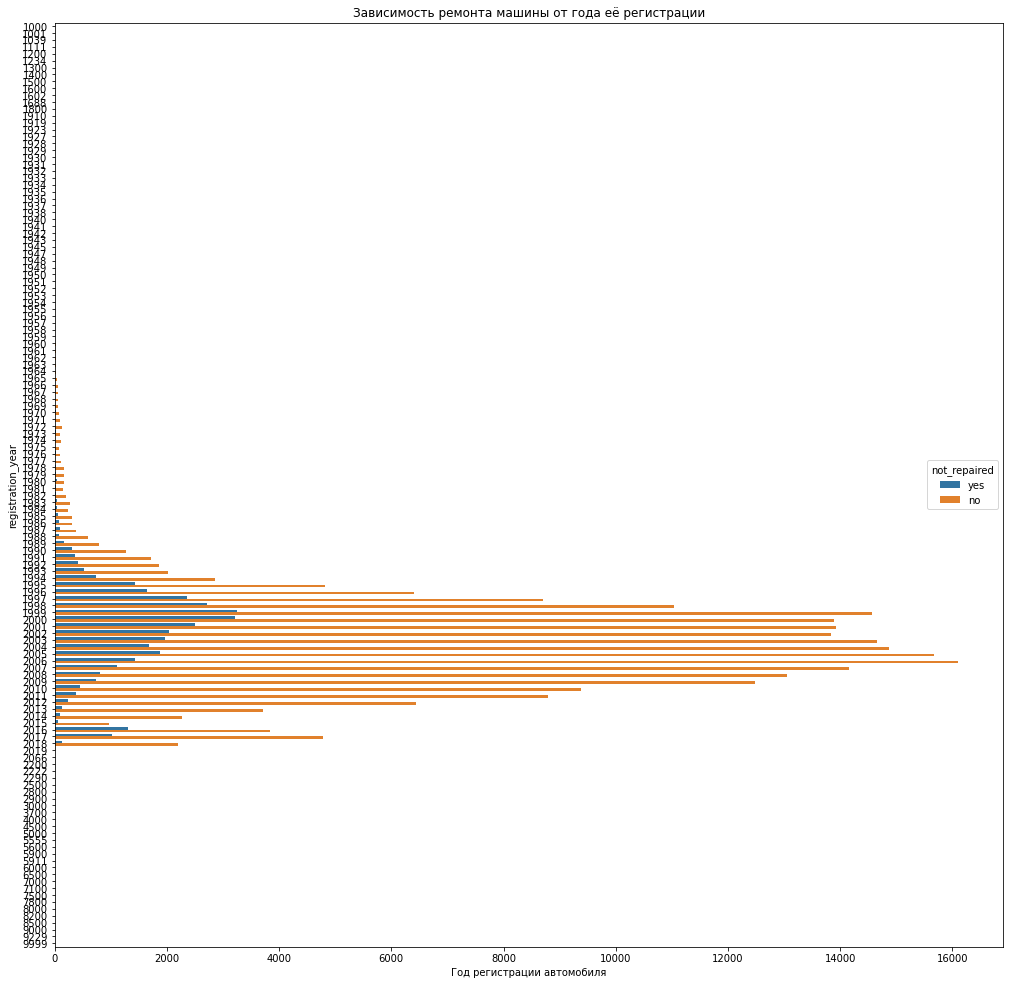

In [36]:
plt.figure(figsize=(17,17))
sb.countplot(data=cars, y=cars['registration_year'], hue='not_repaired')
plt.title('Зависимость ремонта машины от года её регистрации')
plt.xlabel('Количество наблюдений')
plt.xlabel('Год регистрации автомобиля');

Как говорил один философ: "Ничего не понятно, но очень интересно!". Как вариант, можно сделать третью группу машин по этому параметру: 'unknown'. Неизвестно, была ли машина в ремонте или нет.

___

As one philosopher said: "Nothing is clear, but very interesting!". Alternatively, you can make a third group of machines by this parameter: 'unknown'. It is unknown if the car was under repair or not.

In [37]:
cars['not_repaired'].fillna(value='unknown', inplace=True)
cars.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gear_box              0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Заполнили все пропуски. Теперь перейдем к обработке аномальных значений.

All missing values are filled in, but we still are left with anomal values.

### Работа с аномальными значениями / Anomal values treatment

Мы заметили аномалии в следующих переменных:

- price (есть 0, 1, 2, 3, 4, 5 и т.д.). Цена 0 может обозначать, что человек не указал ее в объявлении и она является договорной


- registration_year - есть наблюдения, где автомобиль был зарегистрирован позже, чем было выложено/скачано объявление. Это кажется странным. Также есть значения вообще далекие от правды (1111, 9000, 5000, и т.д),


- power - имеются как низкие значения 0, 1, 2,..., так и очень высокие (20.000). Предполагаю, что где-то указали лишние цифры на конце. У самого мощного спорткара мощность составляет около 2000 л.с., а у нас в данных нет спорткаров (только если машины с типом кузова coupe). Либо записали мощность без десятичного разделителя (мощность может выражаться действительным числом).

____

We found anomalies in the following variables:

- price (there are 0, 1, 2, 3, 4, 5, etc.). Price 0 may mean that the person did not specify it in the ad and it is negotiable


- registration_year - there are observations where the car was registered later than the announcement was posted/downloaded. This seems strange. There are also values that are generally far from the truth (1111, 9000, 5000, etc.),


- power - there are both low values 0, 1, 2,... and very high values (20.000). I assume that somewhere they indicated extra numbers at the end. The most powerful sports car has about 2000 hp, and we don't have sports cars in the data (only if the cars are coupe). Or they wrote down the power without a decimal separator (power can be expressed as a real number).

#### registration_year

Проверим, когда были созданы объявления.

Check the creation date of advertisments.

In [39]:
cars['date_created'].dt.year.unique()

array([2016, 2015, 2014])

У нас объявления за период 2014-2016. Проверим есть ли наблюдения, где год регистрации автомобиля превышает год создания объявления.

____

We have ads for the period 2014-2016. Let's check if there are observations where the year of registration of the car exceeds the year of creation of the ad.

In [40]:
cars[cars['date_created'].dt.year < cars['registration_year']]

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,bus,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,sedan,2017,manual,125,c4,125000,4,gasoline,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,sedan,2017,manual,80,golf,100000,1,petrol,volkswagen,unknown,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,small,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,sedan,2018,manual,64,other,125000,3,gasoline,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,bus,2017,manual,86,transit,150000,5,gasoline,ford,unknown,2016-03-11,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,wagon,2017,manual,101,a4,150000,9,gasoline,audi,unknown,2016-03-29,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,small,2018,manual,80,fiesta,150000,6,petrol,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,small,2018,manual,0,corsa,150000,0,petrol,opel,unknown,2016-03-25,0,45527,2016-04-06 07:46:13


Таких наблюдений 14363 (4%). Процент немалый, но придется удалить, имеем дело с очень важным для предсказания признаком.

____

There are 14363 such observations (4%). The percentage is considerable, but it will have to be removed, we are dealing with a feature that is very important for prediction.

In [41]:
cars = cars[~(cars['date_created'].dt.year < cars['registration_year'])]
cars.shape

(336622, 16)

Теперь необходимо разобраться с неправдоподобными значениями. Посмотрим вообще какие года регистрации есть в данных.

____

Now we need to deal with implausible values. Let's see what years of registration are in the data.

In [42]:
cars['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1300, 1400, 1500, 1600, 1602,
       1688, 1800, 1910, 1919, 1923, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1945,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

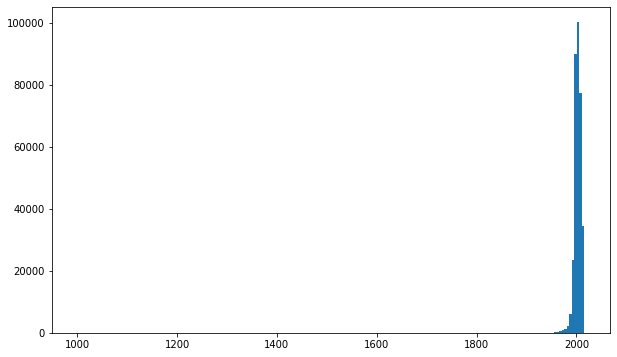

In [45]:
plt.figure(figsize=(10,6))

plt.hist(cars['registration_year'], bins=200);

Видим что слева очень мало значений. Увеличим гистограмму.

A few observations are in the left part of the histogram. Let's zoom in hist.

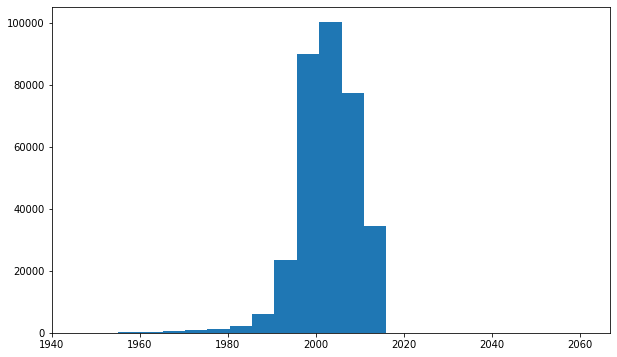

In [46]:
plt.figure(figsize=(10,6))

plt.hist(cars['registration_year'], bins=200)
plt.xlim(1940);

Видим, что до 1980 наблюдений очень мало, их даже не видно на гистограмме. Можем взять это за отсечку по году регистрации машины.

____

We can see that there are very few observations before 1980, they are not even visible on the histogram. We can take this as a cut-off for the year of registration of the car.

In [47]:
cars = cars[cars['registration_year'] >= 1980]

cars['registration_year'].sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

#### power

Посмотрим на распределение величины.

Let's plot **power** histogram.

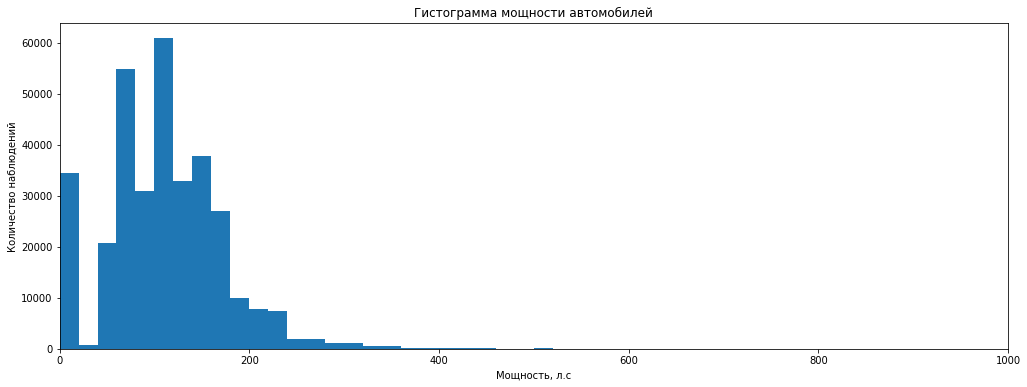

In [48]:
plt.figure(figsize=(17,6))
plt.hist(x=cars['power'], bins=1000)
plt.title('Гистограмма мощности автомобилей')
plt.xlabel('Мощность, л.с')
plt.ylabel('Количество наблюдений')
plt.xlim(0, 1000); # увеличили гистограмму
plt.show()

Есть как очень маленькие так и очень большие значения.

High and low values are observed.

In [49]:
cars['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

Из гистограммы видно, что количество наблюдений с мощность более 400 л.с. единичны. Можем отбросить наблюдения более 400 л.с. как выбросы. Автомобили с 400 л.с. встречаются почаще.

_____

It can be seen from the histogram that the number of observations with a power of more than 400 hp. are single. We can discard observations of more than 400 hp. like emissions. Cars with 400 hp meet more frequently.

In [50]:
cars = cars.query('power <= 400')

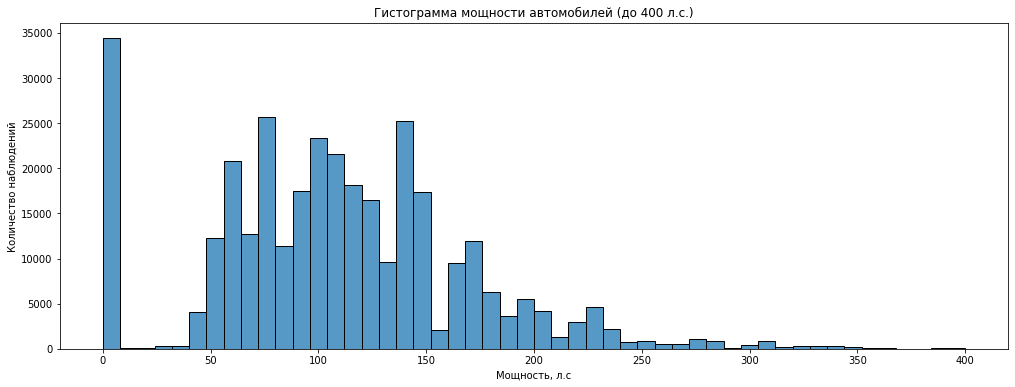

In [51]:
# гистограмма мощностей ниже 400 л.с
plt.figure(figsize=(17,6))
sb.histplot(data=cars['power'], bins=50)
plt.title('Гистограмма мощности автомобилей (до 400 л.с.)')
plt.xlabel('Мощность, л.с')
plt.ylabel('Количество наблюдений');

С аномальными значениями по типу 0, 1 и т.д. (их много) будем бороться следующим образом: после выполнения предыдущего шага посмотрим на среднее значение мощности у автомобилей такого же бренда, модели, и года выпуска. Затем подставим их вместо аномальных значений. Необходимо только определить нижнюю границу, с которой начинаются неправдоподобно низкие мощности.

____

With abnormal values like 0, 1, etc. (there are many) we will deal as follows: after completing the previous step, we will look at the average power value for cars of the same brand, model, and year of manufacture. Then we substitute them for the anomalous values. It is only necessary to determine the lower limit from which unbelievably low powers start.

In [52]:
# определим с какого значения начинаются неправдоподобно низкие мощности
cars.query('power > 0 & power <= 50')

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
23,2016-03-12 19:43:07,450,small,1997,manual,50,arosa,150000,5,petrol,seat,no,2016-03-12,0,9526,2016-03-21 01:46:11
28,2016-03-09 11:56:38,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,2016-03-09,0,87471,2016-03-10 07:44:33
72,2016-03-05 16:45:05,750,small,2002,manual,50,fiesta,150000,4,petrol,ford,no,2016-03-05,0,70327,2016-03-11 06:16:00
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,golf,150000,0,petrol,volkswagen,unknown,2016-03-27,0,83317,2016-04-07 08:17:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354223,2016-03-26 08:37:13,200,small,1991,manual,45,polo,150000,1,petrol,volkswagen,yes,2016-03-26,0,27798,2016-03-29 12:16:52
354266,2016-03-31 16:37:05,399,small,1992,manual,45,polo,150000,4,petrol,volkswagen,unknown,2016-03-31,0,74592,2016-03-31 16:37:05
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32
354358,2016-04-04 09:57:12,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,2016-04-04,0,48653,2016-04-06 11:17:13


У старых автомобилей обычно меньше мощности. Покажем это на графике.

Old cars usually have less power. We can plot it.

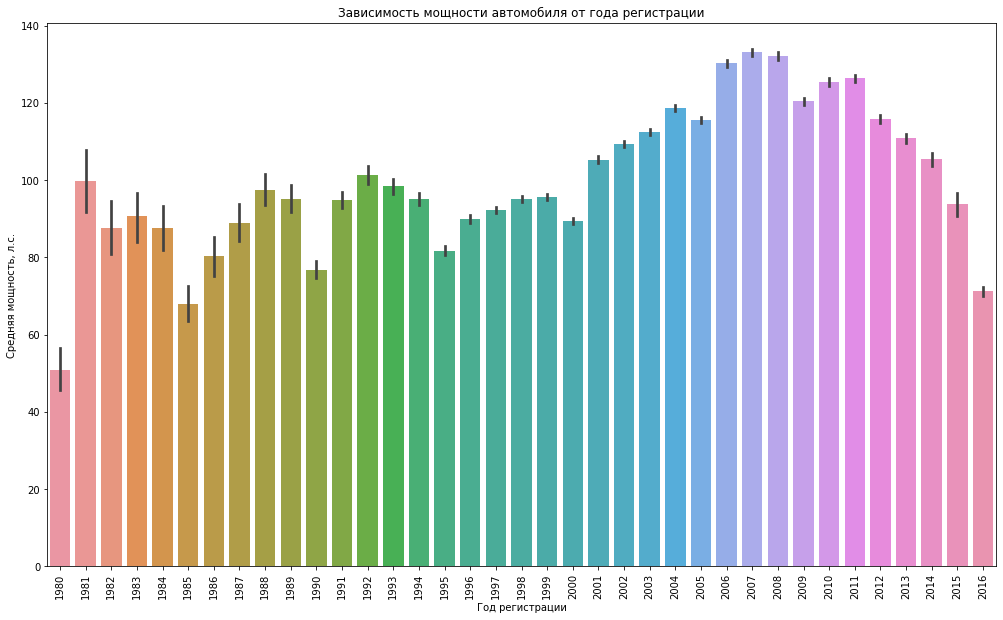

In [53]:
plt.figure(figsize=(17, 10))
sb.barplot(data=cars, x=cars['registration_year'], y='power')
plt.xticks(rotation = 90)
plt.title('Зависимость мощности автомобиля от года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Средняя мощность, л.с.');

Судя по данным, начиная все что ниже 15 лошадиных сил выгляди неправдоподобным. Подставим этим значениям среднюю мощность двигателя такого же автомобиля.

____

Based on the data, starting anything below 15 horsepower seems implausible. Substitute these values for the average engine power of the same car.

Теперь посчитаем среднюю мощность для каждой модели автомобиля и подставим ее той же модели, которая имеет мощность меньше 15 л.с.

____

Now we calculate the average power for each car model and substitute it for the same model that has less than 15 hp.

In [57]:
#создаю разметку в формате pd.Series . В индексах модель, в значениях средняя мощность
mean_power_by_model = cars.groupby('model')['power'].agg(lambda x: x.mean())

# заполняю колонку gear_box на основе колонки model, используя разметку    
cars.loc[cars['power'] < 15, 'power'] = cars.loc[cars['power'] < 15, 'model'].map(mean_power_by_model) 

In [59]:
# проверим минимальное и максимальное значение в колонке
print('Максимальное значение мощности двигателя:', cars['power'].max())
print('Минимальное значение мощности двигателя:', cars['power'].min())

Максимальное значение мощности двигателя: 400.0
Минимальное значение мощности двигателя: 0.0


Остались значения мощности двигателя, равные 0. Посмотрим на них.

We still have power of 0.

In [61]:
cars.query('power < 15')

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
132006,2016-03-09 16:38:02,0,suv,1980,manual,0.00,serie_3,100000,0,gasoline,land_rover,unknown,2016-03-09,0,44787,2016-04-07 03:46:31


Такое наблюдение одно. Все из-за того, что такая модель одна в данных, поэтому ее средняя можность 0. Удалим это наблюдение из данных.

___

There is one such observation. This is because there is only one such model in the data, so its average power is 0. Let's remove this observation from the data.

In [62]:
cars = cars.query('power > 15')

Посмотрим на распределение мощностей еще раз.

Plot **power** distribution once again.

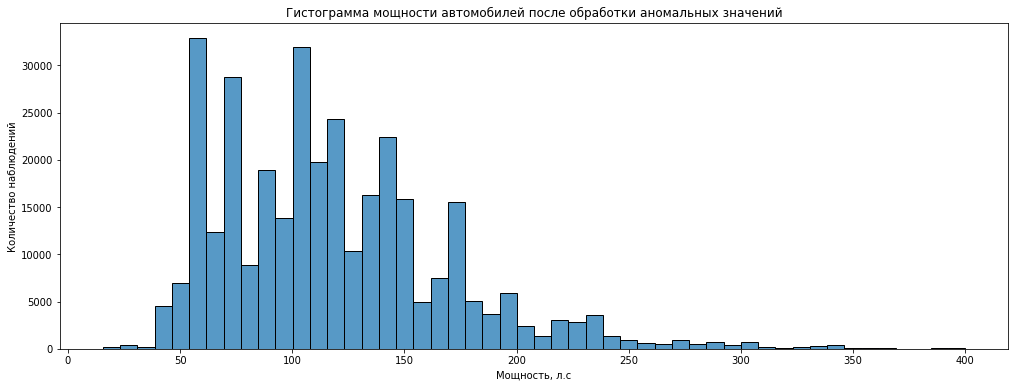

In [63]:
plt.figure(figsize=(17,6))
sb.histplot(data=cars['power'], bins=50)
plt.title('Гистограмма мощности автомобилей после обработки аномальных значений')
plt.xlabel('Мощность, л.с')
plt.ylabel('Количество наблюдений');

В колонке **power** разобрались с аномальными значениями. Двигаемся дальше.

The **power** column has been sorted out with anomalous values. We move on.

#### price

Здесь все сложно. Это целевая колонка. Заменить мы ничего не можем, этим можем исказить нашу модель. Поэтому, мы можем только выделить общую картину по ценам. Затем по выделенным границам убрать аномальные значения.

____

Everything is complicated here. This is the target column. We cannot replace anything, this can distort our model. Therefore, we can only highlight the big picture in terms of prices. Then, along the selected boundaries, remove anomalous values.

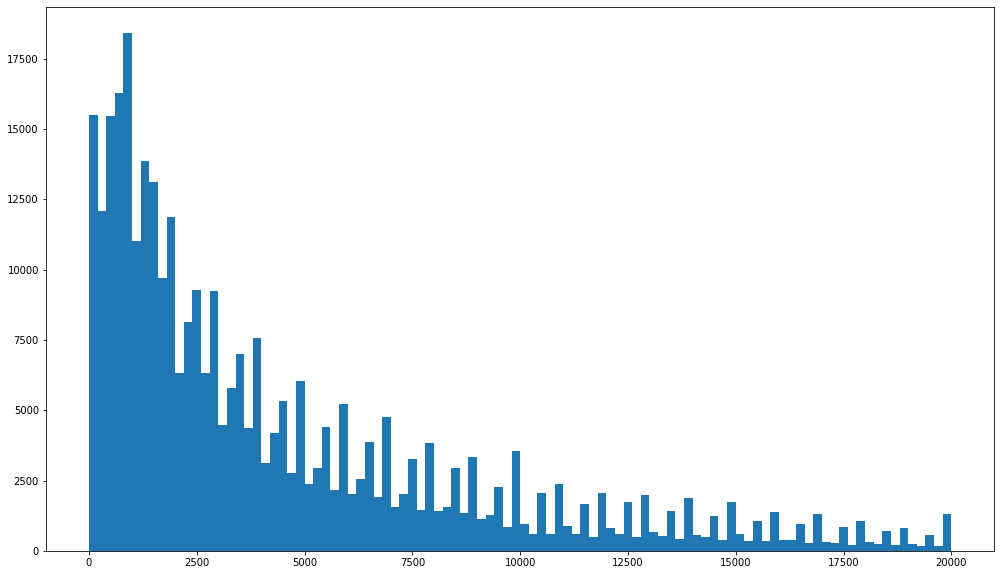

In [71]:
plt.figure(figsize=(17,10))
plt.hist(cars['price'], bins=100);

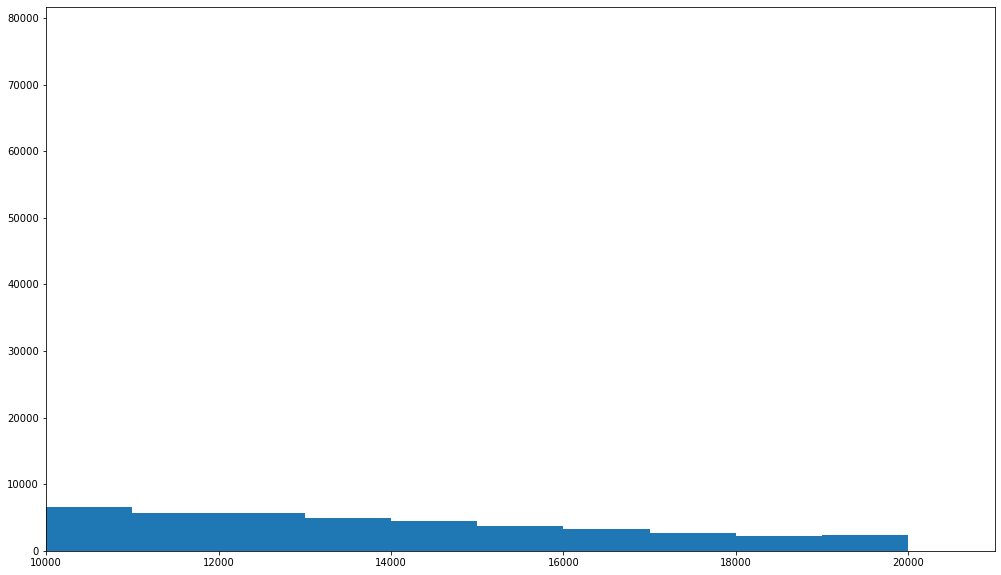

In [63]:
# посмотрим на аномально большие значения / zoom to high values
plt.figure(figsize=(17,10))
plt.hist(cars['price'], bins=20)
plt.xlim(10000);

Гистограмма показывает, что наблюдений с большой ценой довольно много, чтобы построить какие-то закономерности. Сверху отсекать не будем.

Значения с ценой 0 можн осразу удалить и оценить нижний порог отсечения.

____

The histogram shows that there are quite a lot of observations with a large price in order to build some patterns. We will not cut off the top.

Values with a cost of 0 can be immediately removed and the lower cutoff value evaluated.

In [64]:
cars = cars.query('price > 0')

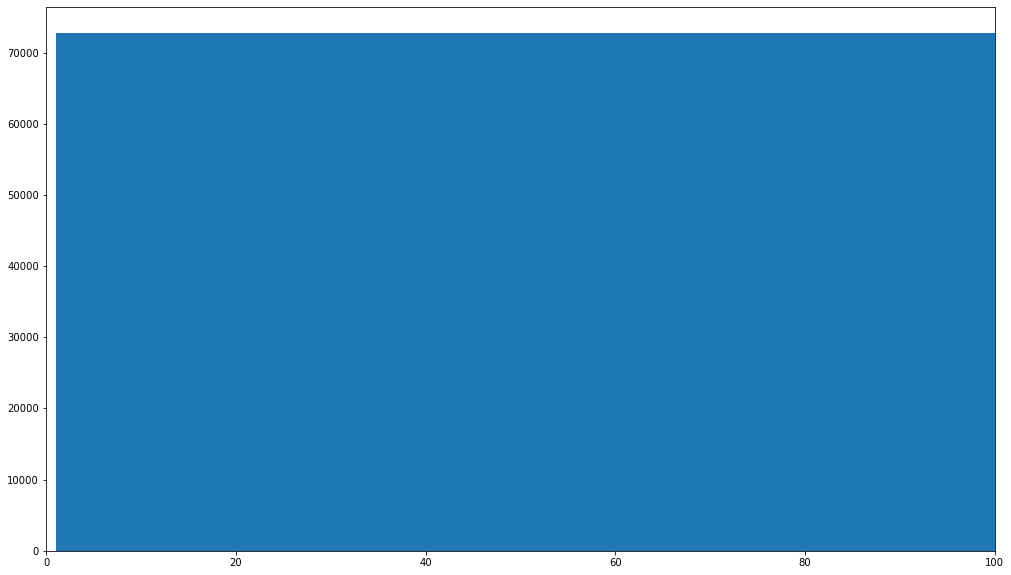

In [65]:
# посмотрим на аномально большие значения
plt.figure(figsize=(17,10))
plt.hist(cars['price'], bins=20)
plt.xlim(0, 100);

Низких цен очень много. Основываясь на данных, начиная с 1 евро есть очень много значений. Конечно, можно было оставить так, у нас же много значений и можно найти какие-то закономерности, но здравый смысл тоже надо оставлять и сопоставлять картину с реальностью. Я не представляю себе как можно купить машину за за цену до 50 евро. Поэтому поставлю отсечку снизу такую.

____

Lots of low prices. Based on the data, starting from 1 euro there are a lot of values. Of course, we could have left it that way, we have many meanings and some patterns can be found, but common sense should also be left and the picture should be compared with reality. I can't imagine how you can buy a car for a price of up to 50 euros. Therefore, I will put a cut-off at the bottom like this.

In [66]:
cars = cars.query('price >= 50')

Посмотрим на гистограмму распределения еще раз.

Plot the price distribution once again.

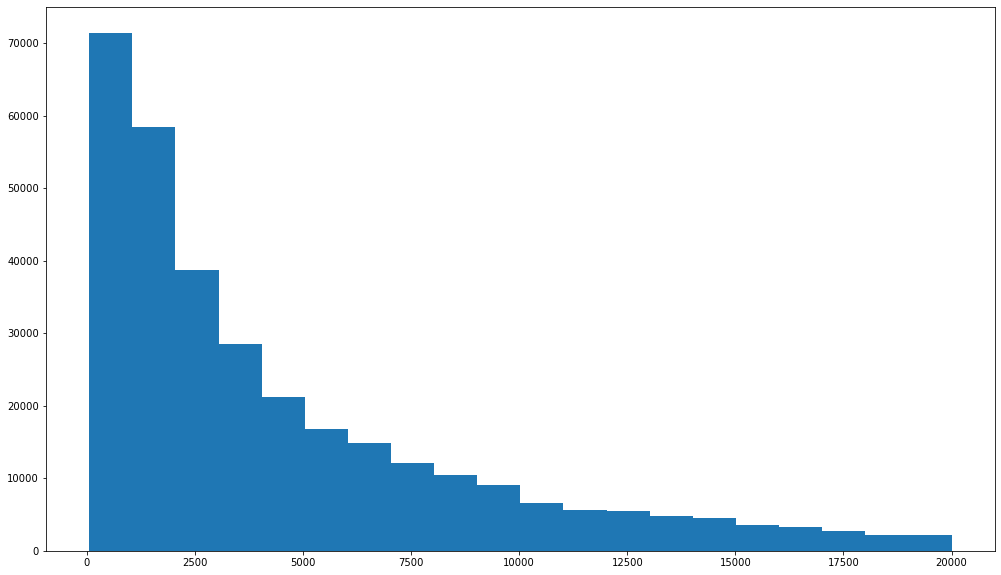

In [67]:
plt.figure(figsize=(17,10))
plt.hist(cars['price'], bins=20);

Теперь надо разобраться со значениями сверху. Дорогой автомобиль будет либо свежим, либо старым (раритетным). Посмотрим на график зависимости цены от года регистрации.

___

Now we need to deal with the values from above. An expensive car will be either fresh or old (rare). Let's look at the graph of the dependence of the price on the year of registration.

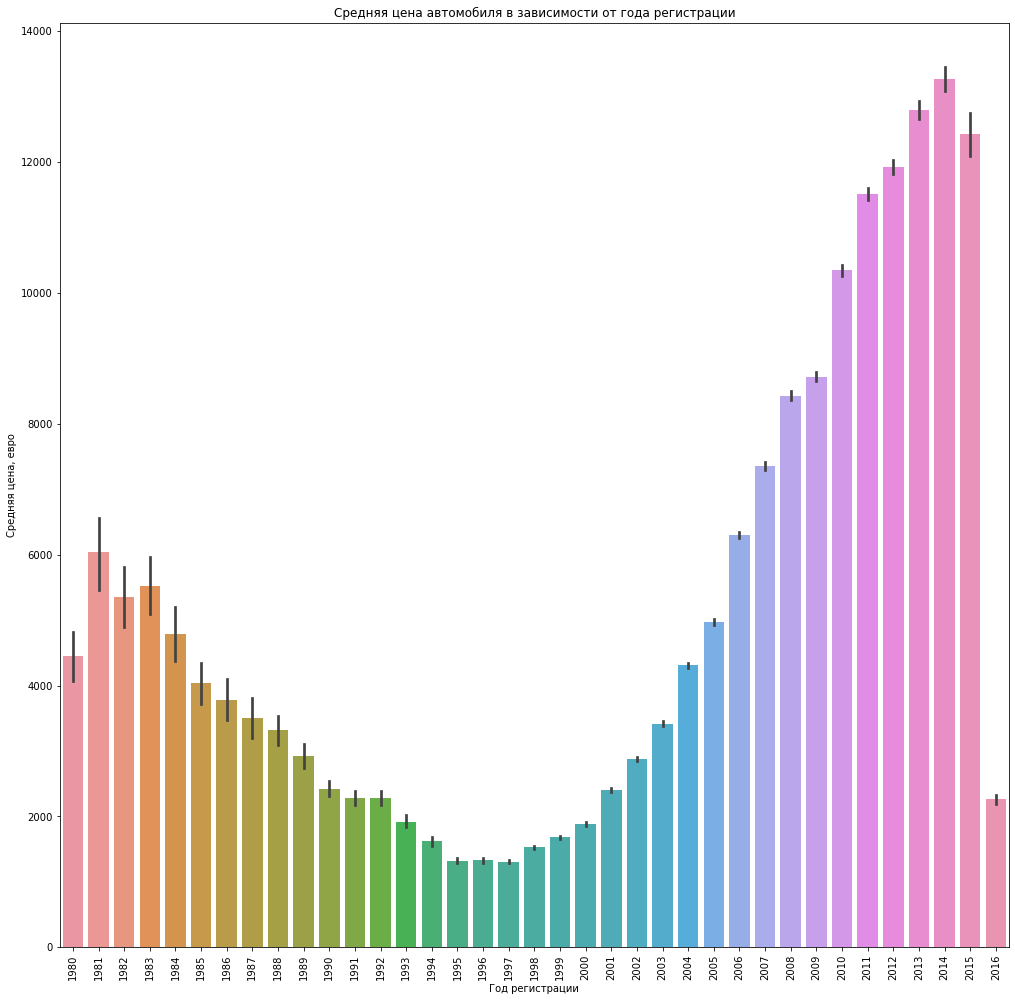

In [73]:
plt.figure(figsize=(17, 17))
sb.barplot(x=cars['registration_year'].sort_values(), y='price', data=cars)
plt.xticks(rotation = 90)
plt.title('Средняя цена автомобиля в зависимости от года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Средняя цена, евро');

График интересный. Видим, что старых автомобилей мало на рынке, поэтому доверительный интервал имеет больший диапазон у этих наблюдений. Также, в 2016 видим аномалию. Из него видно, что средняя цена автомобиля зависит от года регистрации. Можно сказать, что очень старые автомобили стоят дороже (год регистрации так или иначе указывает на возраст автомобиля). Затем с 1980 года автомобиль и не очень старый, и не новый, поэтому цена падает. С примерно 2000 года цены начинают расти, потому что относительно 2016 года, это новые автомобили.

Теперь посмотрим какие автомобили у нас в дорогом диапазоне (10-20 тыс. евро), старые или новые.

____

The plot is interesting. We see that there are few old cars on the market, so the confidence interval has a larger range for these observations. Also, in 2016 we see an anomaly. It shows that the average price of a car depends on the year of registration. We can say that very old cars are more expensive (the year of registration in one way or another indicates the age of the car). Then, since 1980, the car is neither very old nor new, so the price drops. From about 2000, prices begin to rise, because relative to 2016, these are new cars.

### Кодирование категориальных переменных / Categorical features encoding

Следующие переменные являются категориальными:

- vehicle_type - можно применить frequency encoding (заполнение частотностью категории),
- gear_box - frequency encoding,
- model - mean target encoding (заполнение средним таргета по определенной категории),
- fuel_type - frequency encoding,
- brand - mean target encoding,
- not_repaired - frequency_encoding.

Таким образом, мы применим frequency encoding к 4 колонкам, а mean target encoding - к 2.

Применяем mean target encoding к колонкам **model** и **brand** так как они в первую очередь влияют на цену автомобиля.

____

The following variables are categorical:

- vehicle_type - you can apply frequency encoding (filling in the category frequency),
- gear_box - frequency encoding,
- model - mean target encoding (filling in the average target for a certain category),
- fuel_type - frequency encoding,
- brand - mean target encoding,
- not_repaired - frequency_encoding.

So we will apply frequency encoding to 4 columns and mean target encoding to 2.

We apply mean target encoding to the **model** and **brand** columns as they primarily affect the price of the car.

#### Frequency encoding

In [76]:
cols_to_freq_enc = ['vehicle_type', 'gear_box', 'fuel_type', 'not_repaired']

for col in cols_to_freq_enc:
    freq = cars[col].value_counts()
    cars[col] = cars[col].apply(lambda x: freq[x])
    print(cars[col].value_counts()) # выведем количество новых категорий, чтобы проверить правильность заполнения
    print()
    
cars.head()

96600    96600
82692    82692
65278    65278
29413    29413
19330    19330
15039    15039
11396    11396
2722      2722
Name: vehicle_type, dtype: int64

259891    259891
62579      62579
Name: gear_box, dtype: int64

218848    218848
97865      97865
4865        4865
518          518
200          200
112          112
62            62
Name: fuel_type, dtype: int64

232970    232970
57340      57340
32160      32160
Name: not_repaired, dtype: int64



,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,96600,1993,259891,93.21,golf,150000,0,218848,volkswagen,57340,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,15039,2011,259891,190.00,a4,125000,5,97865,audi,32160,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,11396,2004,62579,163.00,grand,125000,8,97865,jeep,57340,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,82692,2001,259891,75.00,golf,150000,6,218848,volkswagen,232970,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,82692,2008,259891,69.00,fabia,90000,7,97865,skoda,232970,2016-03-31,0,60437,2016-04-06 10:17:21


Кодирование категорий их частотами провели верно. Теперь закодируем оставшиеся категориальные переменные методом подсчета среднего целевого признака в определенной категории.

___

The coding of the categories by their frequencies was carried out correctly. Now we encode the remaining categorical variables by calculating the average target feature in a certain category.

#### Mean target encoding

In [77]:
cols_to_mean_enc = ['model', 'brand']

for col in cols_to_mean_enc:
    mean = cars.groupby(col)['price'].mean()
    cars[col] = cars[col].apply(lambda x: mean[x])
    
cars.head()

,date_crawled,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,96600,1993,259891,93.21,"4,201.67",150000,0,218848,"4,585.87",57340,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,15039,2011,259891,190.00,"5,833.98",125000,5,97865,"6,499.48",32160,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,11396,2004,62579,163.00,"6,386.00",125000,8,97865,"7,204.93",57340,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,82692,2001,259891,75.00,"4,201.67",150000,6,218848,"4,585.87",232970,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,82692,2008,259891,69.00,"4,242.78",90000,7,97865,"6,032.81",232970,2016-03-31,0,60437,2016-04-06 10:17:21


Данные готовы, можно переходить к обучению моделей.

Data is ready. We are moving to the model training.

## Обучение моделей Models training

### Выбор признаков / Features selection

Для моделей нам не нужны все столбцы в датасете. Выберем, которые наилучше предскажут цену автомобиля.

Select features that are the best in price prediction.

In [78]:
cars_ml = cars[['price', 'vehicle_type', 'registration_year', 'gear_box', 'power', 'model', 'kilometer',
               'fuel_type', 'brand', 'not_repaired']]

cars_ml.head()

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,not_repaired
0,480,96600,1993,259891,93.21,"4,201.67",150000,218848,"4,585.87",57340
1,18300,15039,2011,259891,190.00,"5,833.98",125000,97865,"6,499.48",32160
2,9800,11396,2004,62579,163.00,"6,386.00",125000,97865,"7,204.93",57340
3,1500,82692,2001,259891,75.00,"4,201.67",150000,218848,"4,585.87",232970
4,3600,82692,2008,259891,69.00,"4,242.78",90000,97865,"6,032.81",232970


In [79]:
cars_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322470 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              322470 non-null  int64  
 1   vehicle_type       322470 non-null  int64  
 2   registration_year  322470 non-null  int64  
 3   gear_box           322470 non-null  int64  
 4   power              322470 non-null  float64
 5   model              322470 non-null  float64
 6   kilometer          322470 non-null  int64  
 7   fuel_type          322470 non-null  int64  
 8   brand              322470 non-null  float64
 9   not_repaired       322470 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 27.1 MB


### Создание обучающей и тестовой выборок / Train/test split

In [81]:
# разделим признаки и таргет
features = cars_ml.drop('price', axis=1)
target = cars_ml['price']

print('Размер выборки с признаками:', features.shape)
print('Размер выборки с таргетом:', target.shape)

Размер выборки с признаками: (322470, 9)
Размер выборки с таргетом: (322470,)


Стандартизируем все численные переменные, чтобы для моделей они были равнозначными, а также для обучения моделей алгоритмом градиентного спуска (со стандартизированными переменными он обучается быстрее).

____

We standardize all numerical variables so that they are equivalent for models, as well as for training models with the gradient descent algorithm (it learns faster with standardized variables).

In [82]:
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(X=features, y=target), columns=features.columns)
features_scaled.head()

,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,not_repaired
0,0.96,-1.66,0.49,-0.49,-0.16,0.57,0.67,-0.00,-1.50
1,-1.82,1.34,0.49,1.40,0.51,-0.11,-1.34,1.27,-1.80
2,-1.94,0.18,-2.04,0.87,0.74,-0.11,-1.34,1.73,-1.50
3,0.49,-0.32,0.49,-0.85,-0.16,0.57,0.67,-0.00,0.62
4,0.49,0.84,0.49,-0.96,-0.14,-1.06,-1.34,0.96,0.62


In [83]:
# разделим на обучающую и тестовую выборки

train_features, test_features, train_target, test_target = train_test_split(features_scaled, target,
                                                                           test_size=0.3, random_state=1)

print('Размер обучающей выборки с признаками:', train_features.shape)
print('Размер тестовой выборки с признаками:', test_features.shape)
print('Размер обучающей выборки с таргетом:', train_target.shape)
print('Размер тестовой выборки с таргетом:', test_target.shape)

Размер обучающей выборки с признаками: (225729, 9)
Размер тестовой выборки с признаками: (96741, 9)
Размер обучающей выборки с таргетом: (225729,)
Размер тестовой выборки с таргетом: (96741,)


### Простая линейная регрессия / Linear regression

Начнем с простой модели, чтобы получить базовую точность и с ней сравнивать остальные модели.

____

Let's start with a simple model to get a baseline accuracy and compare other models against it.

In [84]:
folds = StratifiedKFold(n_splits=5,  shuffle=True, random_state=1) 

In [85]:
model_lr = LinearRegression()

cv_score_lr = abs(cross_val_score(model_lr, train_features,
                                  train_target, cv=folds,
                                  scoring='neg_root_mean_squared_error').mean())

print('RMSE линейной регрессии (кросс-валидация, k=5):', round(cv_score_lr, 2))

RMSE линейной регрессии (кросс-валидация, k=5): 2658.71


Простая модель линейной регрессии выдаёт RMSE 2658.71 предсказании цены автомобиля.

____

A simple linear regression model yields an RMSE of 2658.71 predicting the price of a car.

### Дерево решений / Decision Tree

#### Неоптимизированное дерево решений / Basic decision tree

In [86]:
dt_model_base = DecisionTreeRegressor(random_state=1)

cv_score_dt_base = abs(cross_val_score(dt_model_base, train_features,
                                  train_target, cv=folds,
                                  scoring='neg_root_mean_squared_error').mean())

print('RMSE НЕОПТИМИЗИРОВАННОГО дерева решений (кросс-валидация, k=5):', round(cv_score_dt_base, 2))

RMSE НЕОПТИМИЗИРОВАННОГО дерева решений (кросс-валидация, k=5): 1874.99


Дерево решений без оптимизированных гиперпараметров выдает метрику RMSE при кросс-валидации 1874.99, работает лучше, чем простая линейная регрессия.

____

A decision tree without optimized hyperparameters yields a cross-validation RMSE metric of 1874.99, performs better than simple linear regression.

#### Оптимизированное дерево решений / Optimized decision tree

Деревья решений и случайные леса долго оптимизируются, поэтому будем использовать библиотеку **hyperopt**.

Decision trees and random forests take a long time to optimize, so we will use the **hyperopt** library.

In [87]:
# зададим пространство поиска
params_dt = {
                'max_depth': hp.randint('max_depth', 3, 15),
                'min_samples_leaf': hp.randint('min_samples_leaf', 1, 20),
                'max_leaf_nodes': hp.randint('max_leaf_nodes', 6, 100)
                }

In [88]:
def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 10-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                            scoring='neg_root_mean_squared_error', cv=skf, n_jobs=-1, error_score='raise')

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [89]:
# запускаем hyperopt
trials_dt = Trials()
best_dt = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=dt_model_base, X_train=train_features, y_train=train_target),
          # пространство поиска гиперпараметров  
            space=params_dt,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=100,
          # куда сохранять историю поиска
            trials=trials_dt,
          # random state
            rstate=np.random.default_rng(1),
          # progressbar
            show_progressbar=True
        )

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2022-06-04 11:34:52,999 - INFO     - build_posterior_wrapper took 0.001629 seconds
2022-06-04 11:34:53,003 - INFO     - TPE using 0 trials


  1%|          | 1/100 [00:05<08:16,  5.02s/trial, best loss: 2159.0379381627017]

2022-06-04 11:34:58,022 - INFO     - build_posterior_wrapper took 0.002922 seconds
2022-06-04 11:34:58,024 - INFO     - TPE using 1/1 trials with best loss 2159.037938


  2%|▏         | 2/100 [00:06<05:02,  3.08s/trial, best loss: 2159.0379381627017]

2022-06-04 11:34:59,750 - INFO     - build_posterior_wrapper took 0.002246 seconds
2022-06-04 11:34:59,752 - INFO     - TPE using 2/2 trials with best loss 2159.037938


  3%|▎         | 3/100 [00:08<04:00,  2.48s/trial, best loss: 2159.0379381627017]

2022-06-04 11:35:01,516 - INFO     - build_posterior_wrapper took 0.002055 seconds
2022-06-04 11:35:01,518 - INFO     - TPE using 3/3 trials with best loss 2159.037938


  4%|▍         | 4/100 [00:10<03:51,  2.41s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:03,808 - INFO     - build_posterior_wrapper took 0.003014 seconds
2022-06-04 11:35:03,809 - INFO     - TPE using 4/4 trials with best loss 2075.279298


  5%|▌         | 5/100 [00:12<03:37,  2.29s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:05,896 - INFO     - build_posterior_wrapper took 0.001251 seconds
2022-06-04 11:35:05,897 - INFO     - TPE using 5/5 trials with best loss 2075.279298


  6%|▌         | 6/100 [00:14<03:17,  2.11s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:07,642 - INFO     - build_posterior_wrapper took 0.001909 seconds
2022-06-04 11:35:07,643 - INFO     - TPE using 6/6 trials with best loss 2075.279298


  7%|▋         | 7/100 [00:17<03:29,  2.25s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:10,182 - INFO     - build_posterior_wrapper took 0.001706 seconds
2022-06-04 11:35:10,183 - INFO     - TPE using 7/7 trials with best loss 2075.279298


  8%|▊         | 8/100 [00:19<03:15,  2.12s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:12,041 - INFO     - build_posterior_wrapper took 0.001652 seconds
2022-06-04 11:35:12,042 - INFO     - TPE using 8/8 trials with best loss 2075.279298


  9%|▉         | 9/100 [00:21<03:19,  2.20s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:14,393 - INFO     - build_posterior_wrapper took 0.000801 seconds
2022-06-04 11:35:14,394 - INFO     - TPE using 9/9 trials with best loss 2075.279298


 10%|█         | 10/100 [00:23<03:20,  2.23s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:16,684 - INFO     - build_posterior_wrapper took 0.000993 seconds
2022-06-04 11:35:16,686 - INFO     - TPE using 10/10 trials with best loss 2075.279298


 11%|█         | 11/100 [00:25<03:10,  2.14s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:18,646 - INFO     - build_posterior_wrapper took 0.001266 seconds
2022-06-04 11:35:18,647 - INFO     - TPE using 11/11 trials with best loss 2075.279298


 12%|█▏        | 12/100 [00:27<02:58,  2.02s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:20,394 - INFO     - build_posterior_wrapper took 0.002352 seconds
2022-06-04 11:35:20,396 - INFO     - TPE using 12/12 trials with best loss 2075.279298


 13%|█▎        | 13/100 [00:29<02:57,  2.04s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:22,485 - INFO     - build_posterior_wrapper took 0.001420 seconds
2022-06-04 11:35:22,487 - INFO     - TPE using 13/13 trials with best loss 2075.279298


 14%|█▍        | 14/100 [00:31<02:57,  2.07s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:24,612 - INFO     - build_posterior_wrapper took 0.001896 seconds
2022-06-04 11:35:24,614 - INFO     - TPE using 14/14 trials with best loss 2075.279298


 15%|█▌        | 15/100 [00:33<02:49,  1.99s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:26,435 - INFO     - build_posterior_wrapper took 0.001726 seconds
2022-06-04 11:35:26,437 - INFO     - TPE using 15/15 trials with best loss 2075.279298


 16%|█▌        | 16/100 [00:35<02:41,  1.92s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:28,184 - INFO     - build_posterior_wrapper took 0.003721 seconds
2022-06-04 11:35:28,185 - INFO     - TPE using 16/16 trials with best loss 2075.279298


 17%|█▋        | 17/100 [00:37<02:48,  2.04s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:30,484 - INFO     - build_posterior_wrapper took 0.001670 seconds
2022-06-04 11:35:30,486 - INFO     - TPE using 17/17 trials with best loss 2075.279298


 18%|█▊        | 18/100 [00:39<02:38,  1.93s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:32,179 - INFO     - build_posterior_wrapper took 0.002956 seconds
2022-06-04 11:35:32,181 - INFO     - TPE using 18/18 trials with best loss 2075.279298


 19%|█▉        | 19/100 [00:40<02:27,  1.82s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:33,751 - INFO     - build_posterior_wrapper took 0.002107 seconds
2022-06-04 11:35:33,752 - INFO     - TPE using 19/19 trials with best loss 2075.279298


 20%|██        | 20/100 [00:42<02:27,  1.84s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:35,622 - INFO     - build_posterior_wrapper took 0.002168 seconds
2022-06-04 11:35:35,623 - INFO     - TPE using 20/20 trials with best loss 2075.279298


 21%|██        | 21/100 [00:44<02:24,  1.83s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:37,447 - INFO     - build_posterior_wrapper took 0.002281 seconds
2022-06-04 11:35:37,449 - INFO     - TPE using 21/21 trials with best loss 2075.279298


 22%|██▏       | 22/100 [00:46<02:28,  1.90s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:39,496 - INFO     - build_posterior_wrapper took 0.002133 seconds
2022-06-04 11:35:39,499 - INFO     - TPE using 22/22 trials with best loss 2075.279298


 23%|██▎       | 23/100 [00:48<02:33,  2.00s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:41,717 - INFO     - build_posterior_wrapper took 0.001236 seconds
2022-06-04 11:35:41,719 - INFO     - TPE using 23/23 trials with best loss 2075.279298


 24%|██▍       | 24/100 [00:50<02:33,  2.02s/trial, best loss: 2075.2792980667637]

2022-06-04 11:35:43,806 - INFO     - build_posterior_wrapper took 0.001359 seconds
2022-06-04 11:35:43,807 - INFO     - TPE using 24/24 trials with best loss 2075.279298


 25%|██▌       | 25/100 [00:53<02:38,  2.11s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:46,126 - INFO     - build_posterior_wrapper took 0.002182 seconds
2022-06-04 11:35:46,129 - INFO     - TPE using 25/25 trials with best loss 2045.889016


 26%|██▌       | 26/100 [00:55<02:33,  2.08s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:48,128 - INFO     - build_posterior_wrapper took 0.001516 seconds
2022-06-04 11:35:48,130 - INFO     - TPE using 26/26 trials with best loss 2045.889016


 27%|██▋       | 27/100 [00:57<02:32,  2.08s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:50,225 - INFO     - build_posterior_wrapper took 0.002603 seconds
2022-06-04 11:35:50,227 - INFO     - TPE using 27/27 trials with best loss 2045.889016


 28%|██▊       | 28/100 [00:59<02:34,  2.14s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:52,498 - INFO     - build_posterior_wrapper took 0.001856 seconds
2022-06-04 11:35:52,501 - INFO     - TPE using 28/28 trials with best loss 2045.889016


 29%|██▉       | 29/100 [01:01<02:26,  2.06s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:54,386 - INFO     - build_posterior_wrapper took 0.002700 seconds
2022-06-04 11:35:54,388 - INFO     - TPE using 29/29 trials with best loss 2045.889016


 30%|███       | 30/100 [01:03<02:26,  2.10s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:56,568 - INFO     - build_posterior_wrapper took 0.002880 seconds
2022-06-04 11:35:56,570 - INFO     - TPE using 30/30 trials with best loss 2045.889016


 31%|███       | 31/100 [01:05<02:24,  2.09s/trial, best loss: 2045.8890163033404]

2022-06-04 11:35:58,644 - INFO     - build_posterior_wrapper took 0.001364 seconds
2022-06-04 11:35:58,645 - INFO     - TPE using 31/31 trials with best loss 2045.889016


 32%|███▏      | 32/100 [01:07<02:23,  2.10s/trial, best loss: 2045.8890163033404]

2022-06-04 11:36:00,775 - INFO     - build_posterior_wrapper took 0.001979 seconds
2022-06-04 11:36:00,777 - INFO     - TPE using 32/32 trials with best loss 2045.889016


 33%|███▎      | 33/100 [01:10<02:23,  2.15s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:03,022 - INFO     - build_posterior_wrapper took 0.001917 seconds
2022-06-04 11:36:03,023 - INFO     - TPE using 33/33 trials with best loss 2045.801049


 34%|███▍      | 34/100 [01:12<02:18,  2.10s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:05,009 - INFO     - build_posterior_wrapper took 0.001085 seconds
2022-06-04 11:36:05,011 - INFO     - TPE using 34/34 trials with best loss 2045.801049


 35%|███▌      | 35/100 [01:14<02:19,  2.14s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:07,249 - INFO     - build_posterior_wrapper took 0.001369 seconds
2022-06-04 11:36:07,250 - INFO     - TPE using 35/35 trials with best loss 2045.801049


 36%|███▌      | 36/100 [01:16<02:14,  2.11s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:09,276 - INFO     - build_posterior_wrapper took 0.002343 seconds
2022-06-04 11:36:09,278 - INFO     - TPE using 36/36 trials with best loss 2045.801049


 37%|███▋      | 37/100 [01:18<02:07,  2.03s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:11,132 - INFO     - build_posterior_wrapper took 0.001887 seconds
2022-06-04 11:36:11,134 - INFO     - TPE using 37/37 trials with best loss 2045.801049


 38%|███▊      | 38/100 [01:19<02:01,  1.96s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:12,920 - INFO     - build_posterior_wrapper took 0.002311 seconds
2022-06-04 11:36:12,921 - INFO     - TPE using 38/38 trials with best loss 2045.801049


 39%|███▉      | 39/100 [01:22<02:02,  2.01s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:15,065 - INFO     - build_posterior_wrapper took 0.001786 seconds
2022-06-04 11:36:15,066 - INFO     - TPE using 39/39 trials with best loss 2045.801049


 40%|████      | 40/100 [01:24<02:01,  2.03s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:17,132 - INFO     - build_posterior_wrapper took 0.001144 seconds
2022-06-04 11:36:17,133 - INFO     - TPE using 40/40 trials with best loss 2045.801049


 41%|████      | 41/100 [01:26<02:02,  2.08s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:19,312 - INFO     - build_posterior_wrapper took 0.001572 seconds
2022-06-04 11:36:19,314 - INFO     - TPE using 41/41 trials with best loss 2045.801049


 42%|████▏     | 42/100 [01:28<01:56,  2.01s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:21,159 - INFO     - build_posterior_wrapper took 0.002697 seconds
2022-06-04 11:36:21,161 - INFO     - TPE using 42/42 trials with best loss 2045.801049


 43%|████▎     | 43/100 [01:30<01:53,  1.99s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:23,127 - INFO     - build_posterior_wrapper took 0.002934 seconds
2022-06-04 11:36:23,130 - INFO     - TPE using 43/43 trials with best loss 2045.801049


 44%|████▍     | 44/100 [01:32<01:55,  2.06s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:25,337 - INFO     - build_posterior_wrapper took 0.002368 seconds
2022-06-04 11:36:25,339 - INFO     - TPE using 44/44 trials with best loss 2045.801049


 45%|████▌     | 45/100 [01:34<01:52,  2.05s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:27,356 - INFO     - build_posterior_wrapper took 0.003005 seconds
2022-06-04 11:36:27,358 - INFO     - TPE using 45/45 trials with best loss 2045.801049


 46%|████▌     | 46/100 [01:36<01:51,  2.07s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:29,472 - INFO     - build_posterior_wrapper took 0.001483 seconds
2022-06-04 11:36:29,473 - INFO     - TPE using 46/46 trials with best loss 2045.801049


 47%|████▋     | 47/100 [01:38<01:46,  2.01s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:31,350 - INFO     - build_posterior_wrapper took 0.002242 seconds
2022-06-04 11:36:31,352 - INFO     - TPE using 47/47 trials with best loss 2045.801049


 48%|████▊     | 48/100 [01:40<01:47,  2.06s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:33,523 - INFO     - build_posterior_wrapper took 0.001759 seconds
2022-06-04 11:36:33,525 - INFO     - TPE using 48/48 trials with best loss 2045.801049


 49%|████▉     | 49/100 [01:42<01:42,  2.01s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:35,401 - INFO     - build_posterior_wrapper took 0.001062 seconds
2022-06-04 11:36:35,403 - INFO     - TPE using 49/49 trials with best loss 2045.801049


 50%|█████     | 50/100 [01:44<01:40,  2.00s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:37,394 - INFO     - build_posterior_wrapper took 0.002864 seconds
2022-06-04 11:36:37,396 - INFO     - TPE using 50/50 trials with best loss 2045.801049


 51%|█████     | 51/100 [01:46<01:33,  1.92s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:39,112 - INFO     - build_posterior_wrapper took 0.002566 seconds
2022-06-04 11:36:39,114 - INFO     - TPE using 51/51 trials with best loss 2045.801049


 52%|█████▏    | 52/100 [01:48<01:33,  1.95s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:41,124 - INFO     - build_posterior_wrapper took 0.002715 seconds
2022-06-04 11:36:41,126 - INFO     - TPE using 52/52 trials with best loss 2045.801049


 53%|█████▎    | 53/100 [01:50<01:37,  2.07s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:43,472 - INFO     - build_posterior_wrapper took 0.002859 seconds
2022-06-04 11:36:43,473 - INFO     - TPE using 53/53 trials with best loss 2045.801049


 54%|█████▍    | 54/100 [01:52<01:28,  1.93s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:45,068 - INFO     - build_posterior_wrapper took 0.001246 seconds
2022-06-04 11:36:45,071 - INFO     - TPE using 54/54 trials with best loss 2045.801049


 55%|█████▌    | 55/100 [01:53<01:22,  1.84s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:46,708 - INFO     - build_posterior_wrapper took 0.002154 seconds
2022-06-04 11:36:46,710 - INFO     - TPE using 55/55 trials with best loss 2045.801049


 56%|█████▌    | 56/100 [01:55<01:25,  1.93s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:48,858 - INFO     - build_posterior_wrapper took 0.002226 seconds
2022-06-04 11:36:48,860 - INFO     - TPE using 56/56 trials with best loss 2045.801049


 57%|█████▋    | 57/100 [01:57<01:24,  1.96s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:50,868 - INFO     - build_posterior_wrapper took 0.001979 seconds
2022-06-04 11:36:50,870 - INFO     - TPE using 57/57 trials with best loss 2045.801049


 58%|█████▊    | 58/100 [01:59<01:23,  2.00s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:52,970 - INFO     - build_posterior_wrapper took 0.001777 seconds
2022-06-04 11:36:52,972 - INFO     - TPE using 58/58 trials with best loss 2045.801049


 59%|█████▉    | 59/100 [02:01<01:19,  1.94s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:54,759 - INFO     - build_posterior_wrapper took 0.001809 seconds
2022-06-04 11:36:54,762 - INFO     - TPE using 59/59 trials with best loss 2045.801049


 60%|██████    | 60/100 [02:03<01:20,  2.02s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:56,986 - INFO     - build_posterior_wrapper took 0.001975 seconds
2022-06-04 11:36:56,989 - INFO     - TPE using 60/60 trials with best loss 2045.801049


 61%|██████    | 61/100 [02:06<01:21,  2.10s/trial, best loss: 2045.8010485642158]

2022-06-04 11:36:59,248 - INFO     - build_posterior_wrapper took 0.001695 seconds
2022-06-04 11:36:59,250 - INFO     - TPE using 61/61 trials with best loss 2045.801049


 62%|██████▏   | 62/100 [02:07<01:13,  1.92s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:00,763 - INFO     - build_posterior_wrapper took 0.001567 seconds
2022-06-04 11:37:00,764 - INFO     - TPE using 62/62 trials with best loss 2045.801049


 63%|██████▎   | 63/100 [02:09<01:08,  1.84s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:02,420 - INFO     - build_posterior_wrapper took 0.001563 seconds
2022-06-04 11:37:02,421 - INFO     - TPE using 63/63 trials with best loss 2045.801049


 64%|██████▍   | 64/100 [02:11<01:03,  1.77s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:04,020 - INFO     - build_posterior_wrapper took 0.002589 seconds
2022-06-04 11:37:04,022 - INFO     - TPE using 64/64 trials with best loss 2045.801049


 65%|██████▌   | 65/100 [02:12<01:03,  1.82s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:05,974 - INFO     - build_posterior_wrapper took 0.002421 seconds
2022-06-04 11:37:05,976 - INFO     - TPE using 65/65 trials with best loss 2045.801049


 66%|██████▌   | 66/100 [02:15<01:07,  1.97s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:08,286 - INFO     - build_posterior_wrapper took 0.002027 seconds
2022-06-04 11:37:08,287 - INFO     - TPE using 66/66 trials with best loss 2045.801049


 67%|██████▋   | 67/100 [02:17<01:08,  2.06s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:10,565 - INFO     - build_posterior_wrapper took 0.002259 seconds
2022-06-04 11:37:10,567 - INFO     - TPE using 67/67 trials with best loss 2045.801049


 68%|██████▊   | 68/100 [02:19<01:05,  2.05s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:12,585 - INFO     - build_posterior_wrapper took 0.001587 seconds
2022-06-04 11:37:12,587 - INFO     - TPE using 68/68 trials with best loss 2045.801049


 69%|██████▉   | 69/100 [02:21<01:02,  2.01s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:14,516 - INFO     - build_posterior_wrapper took 0.001657 seconds
2022-06-04 11:37:14,518 - INFO     - TPE using 69/69 trials with best loss 2045.801049


 70%|███████   | 70/100 [02:23<00:58,  1.94s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:16,294 - INFO     - build_posterior_wrapper took 0.001857 seconds
2022-06-04 11:37:16,296 - INFO     - TPE using 70/70 trials with best loss 2045.801049


 71%|███████   | 71/100 [02:25<00:56,  1.95s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:18,271 - INFO     - build_posterior_wrapper took 0.002242 seconds
2022-06-04 11:37:18,273 - INFO     - TPE using 71/71 trials with best loss 2045.801049


 72%|███████▏  | 72/100 [02:27<00:53,  1.92s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:20,117 - INFO     - build_posterior_wrapper took 0.001744 seconds
2022-06-04 11:37:20,118 - INFO     - TPE using 72/72 trials with best loss 2045.801049


 73%|███████▎  | 73/100 [02:29<00:52,  1.96s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:22,152 - INFO     - build_posterior_wrapper took 0.002280 seconds
2022-06-04 11:37:22,155 - INFO     - TPE using 73/73 trials with best loss 2045.801049


 74%|███████▍  | 74/100 [02:31<00:50,  1.94s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:24,048 - INFO     - build_posterior_wrapper took 0.001241 seconds
2022-06-04 11:37:24,050 - INFO     - TPE using 74/74 trials with best loss 2045.801049


 75%|███████▌  | 75/100 [02:32<00:47,  1.88s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:25,794 - INFO     - build_posterior_wrapper took 0.001568 seconds
2022-06-04 11:37:25,797 - INFO     - TPE using 75/75 trials with best loss 2045.801049


 76%|███████▌  | 76/100 [02:34<00:47,  1.96s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:27,936 - INFO     - build_posterior_wrapper took 0.002208 seconds
2022-06-04 11:37:27,937 - INFO     - TPE using 76/76 trials with best loss 2045.801049


 77%|███████▋  | 77/100 [02:37<00:47,  2.04s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:30,177 - INFO     - build_posterior_wrapper took 0.001906 seconds
2022-06-04 11:37:30,179 - INFO     - TPE using 77/77 trials with best loss 2045.801049


 78%|███████▊  | 78/100 [02:38<00:42,  1.95s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:31,917 - INFO     - build_posterior_wrapper took 0.001782 seconds
2022-06-04 11:37:31,919 - INFO     - TPE using 78/78 trials with best loss 2045.801049


 79%|███████▉  | 79/100 [02:41<00:42,  2.02s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:34,110 - INFO     - build_posterior_wrapper took 0.003068 seconds
2022-06-04 11:37:34,112 - INFO     - TPE using 79/79 trials with best loss 2045.801049


 80%|████████  | 80/100 [02:43<00:41,  2.06s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:36,254 - INFO     - build_posterior_wrapper took 0.001628 seconds
2022-06-04 11:37:36,256 - INFO     - TPE using 80/80 trials with best loss 2045.801049


 81%|████████  | 81/100 [02:45<00:38,  2.05s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:38,276 - INFO     - build_posterior_wrapper took 0.001982 seconds
2022-06-04 11:37:38,278 - INFO     - TPE using 81/81 trials with best loss 2045.801049


 82%|████████▏ | 82/100 [02:46<00:34,  1.92s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:39,897 - INFO     - build_posterior_wrapper took 0.002290 seconds
2022-06-04 11:37:39,900 - INFO     - TPE using 82/82 trials with best loss 2045.801049


 83%|████████▎ | 83/100 [02:48<00:31,  1.85s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:41,575 - INFO     - build_posterior_wrapper took 0.002060 seconds
2022-06-04 11:37:41,578 - INFO     - TPE using 83/83 trials with best loss 2045.801049


 84%|████████▍ | 84/100 [02:50<00:31,  1.97s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:43,815 - INFO     - build_posterior_wrapper took 0.001399 seconds
2022-06-04 11:37:43,817 - INFO     - TPE using 84/84 trials with best loss 2045.801049


 85%|████████▌ | 85/100 [02:52<00:28,  1.91s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:45,602 - INFO     - build_posterior_wrapper took 0.001985 seconds
2022-06-04 11:37:45,604 - INFO     - TPE using 85/85 trials with best loss 2045.801049


 86%|████████▌ | 86/100 [02:54<00:27,  1.96s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:47,670 - INFO     - build_posterior_wrapper took 0.001308 seconds
2022-06-04 11:37:47,671 - INFO     - TPE using 86/86 trials with best loss 2045.801049


 87%|████████▋ | 87/100 [02:56<00:25,  1.98s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:49,708 - INFO     - build_posterior_wrapper took 0.002057 seconds
2022-06-04 11:37:49,711 - INFO     - TPE using 87/87 trials with best loss 2045.801049


 88%|████████▊ | 88/100 [02:58<00:24,  2.02s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:51,807 - INFO     - build_posterior_wrapper took 0.001290 seconds
2022-06-04 11:37:51,808 - INFO     - TPE using 88/88 trials with best loss 2045.801049


 89%|████████▉ | 89/100 [03:00<00:22,  2.06s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:53,978 - INFO     - build_posterior_wrapper took 0.001796 seconds
2022-06-04 11:37:53,982 - INFO     - TPE using 89/89 trials with best loss 2045.801049


 90%|█████████ | 90/100 [03:02<00:20,  2.02s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:55,888 - INFO     - build_posterior_wrapper took 0.001818 seconds
2022-06-04 11:37:55,890 - INFO     - TPE using 90/90 trials with best loss 2045.801049


 91%|█████████ | 91/100 [03:05<00:18,  2.07s/trial, best loss: 2045.8010485642158]

2022-06-04 11:37:58,081 - INFO     - build_posterior_wrapper took 0.001210 seconds
2022-06-04 11:37:58,082 - INFO     - TPE using 91/91 trials with best loss 2045.801049


 92%|█████████▏| 92/100 [03:07<00:16,  2.12s/trial, best loss: 2043.956337720058] 

2022-06-04 11:38:00,303 - INFO     - build_posterior_wrapper took 0.001039 seconds
2022-06-04 11:38:00,304 - INFO     - TPE using 92/92 trials with best loss 2043.956338


 93%|█████████▎| 93/100 [03:09<00:15,  2.16s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:02,552 - INFO     - build_posterior_wrapper took 0.001879 seconds
2022-06-04 11:38:02,554 - INFO     - TPE using 93/93 trials with best loss 2043.956338


 94%|█████████▍| 94/100 [03:11<00:12,  2.14s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:04,666 - INFO     - build_posterior_wrapper took 0.002780 seconds
2022-06-04 11:38:04,667 - INFO     - TPE using 94/94 trials with best loss 2043.956338


 95%|█████████▌| 95/100 [03:13<00:10,  2.19s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:06,967 - INFO     - build_posterior_wrapper took 0.001766 seconds
2022-06-04 11:38:06,970 - INFO     - TPE using 95/95 trials with best loss 2043.956338


 96%|█████████▌| 96/100 [03:16<00:08,  2.19s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:09,156 - INFO     - build_posterior_wrapper took 0.002769 seconds
2022-06-04 11:38:09,157 - INFO     - TPE using 96/96 trials with best loss 2043.956338


 97%|█████████▋| 97/100 [03:18<00:06,  2.22s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:11,460 - INFO     - build_posterior_wrapper took 0.001044 seconds
2022-06-04 11:38:11,461 - INFO     - TPE using 97/97 trials with best loss 2043.956338


 98%|█████████▊| 98/100 [03:20<00:04,  2.22s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:13,666 - INFO     - build_posterior_wrapper took 0.002400 seconds
2022-06-04 11:38:13,669 - INFO     - TPE using 98/98 trials with best loss 2043.956338


 99%|█████████▉| 99/100 [03:22<00:02,  2.21s/trial, best loss: 2043.956337720058]

2022-06-04 11:38:15,858 - INFO     - build_posterior_wrapper took 0.001756 seconds
2022-06-04 11:38:15,860 - INFO     - TPE using 99/99 trials with best loss 2043.956338


100%|██████████| 100/100 [03:25<00:00,  2.05s/trial, best loss: 2043.956337720058]


In [92]:
# запишем новую оптимизированную модель дерева решений
dt_model_opt = DecisionTreeRegressor(**best_dt, random_state=1)
print('Гиперпараметры для лучшего дерева решений:', best_dt)

Гиперпараметры для лучшего дерева решений: {'max_depth': 10, 'max_leaf_nodes': 99, 'min_samples_leaf': 2}


In [93]:
# напишем функцию для отображения результата оптимизации в виде датафрэйма
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    return results

In [94]:
dt_opt_results = df_results(trials_dt.results)
dt_opt_results

,loss,max_depth,max_leaf_nodes,min_samples_leaf
74,"2,939.34",13,6,15
63,"2,866.93",5,7,10
9,"2,839.16",3,93,11
81,"2,839.16",3,8,7
18,"2,839.16",3,69,2
...,...,...,...,...
91,"2,043.96",10,99,2
95,"2,043.96",10,99,2
97,"2,043.96",10,99,2
98,"2,043.96",10,99,2


In [96]:
print('RMSE ОПТИМИЗИРОВАННОГО дерева решений:', round(dt_opt_results['loss'].min(), 2))

RMSE ОПТИМИЗИРОВАННОГО дерева решений: 2043.96


Дерево решений с гиперпараметрами max_depth=9, min_samples_leaf=12, max_leaf_nodes=98 выдает наименьшее RMSE равное 2043.96. Оптимизацией гиперпараметров мы ухудшили метрику RMSE.

____

A decision tree with hyperparameters max_depth=9, min_samples_leaf=12, max_leaf_nodes=98 gives the smallest RMSE equal to 2043.96. By optimizing hyperparameters, we worsened the RMSE metric.

### Случайный лес / Random forest

#### Неоптимизированный случайный лес / Basic random forest

In [97]:
rf_model_base = RandomForestRegressor(random_state=1)

cv_score_rf_base = abs(cross_val_score(rf_model_base, train_features,
                                  train_target, cv=folds,
                                  scoring='neg_root_mean_squared_error').mean())

print('RMSE НЕОПТИМИЗИРОВАННОГО случайного леса (кросс-валидация, k=5):', round(cv_score_rf_base, 2))

RMSE НЕОПТИМИЗИРОВАННОГО случайного леса (кросс-валидация, k=5): 1545.24


Неоптимизированный случайный лес выдает результат еще лучше, снизив метрику RMSE до 1545.24 (7,8%).

The unoptimized random forest performs even better, dropping the RMSE metric to 1545.24 (7.8%).

#### Оптимизированный случайный лес / Optimized random forest

In [98]:
# зададим пространство интересуемых параметров
params_rf = {
        'n_estimators': hp.randint('n_estimators', 10, 600),
        'min_samples_leaf': hp.randint('min_samples_leaf', 1, 20),
        'max_depth': hp.randint('max_depth', 3, 15),
        'max_leaf_nodes': hp.randint('max_leaf_nodes', 6, 100)
        }
        
# запускаем hyperopt
trials_rf = Trials()
best_rf = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=rf_model_base, X_train=train_features, y_train=train_target),
          # пространство поиска гиперпараметров  
            space=params_rf,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=20,
          # куда сохранять историю поиска
            trials=trials_rf,
          # random state
            rstate=np.random.default_rng(1),
          # progressbar
            show_progressbar=True
        )

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2022-06-04 11:44:25,495 - INFO     - build_posterior_wrapper took 0.001831 seconds
2022-06-04 11:44:25,496 - INFO     - TPE using 0 trials


  5%|▌         | 1/20 [02:13<42:17, 133.53s/trial, best loss: 2128.6295969410103]

2022-06-04 11:46:39,023 - INFO     - build_posterior_wrapper took 0.001420 seconds
2022-06-04 11:46:39,025 - INFO     - TPE using 1/1 trials with best loss 2128.629597


 10%|█         | 2/20 [03:18<27:56, 93.12s/trial, best loss: 2128.6295969410103] 

2022-06-04 11:47:43,866 - INFO     - build_posterior_wrapper took 0.003183 seconds
2022-06-04 11:47:43,868 - INFO     - TPE using 2/2 trials with best loss 2128.629597


 15%|█▌        | 3/20 [03:40<17:11, 60.65s/trial, best loss: 2128.6295969410103]

2022-06-04 11:48:05,879 - INFO     - build_posterior_wrapper took 0.002227 seconds
2022-06-04 11:48:05,882 - INFO     - TPE using 3/3 trials with best loss 2128.629597


 20%|██        | 4/20 [11:48<1:01:08, 229.28s/trial, best loss: 2033.4741996018759]

2022-06-04 11:56:13,669 - INFO     - build_posterior_wrapper took 0.001846 seconds
2022-06-04 11:56:13,671 - INFO     - TPE using 4/4 trials with best loss 2033.474200


 25%|██▌       | 5/20 [19:52<1:20:19, 321.27s/trial, best loss: 2033.4741996018759]

2022-06-04 12:04:18,045 - INFO     - build_posterior_wrapper took 0.004282 seconds
2022-06-04 12:04:18,047 - INFO     - TPE using 5/5 trials with best loss 2033.474200


 30%|███       | 6/20 [21:48<58:41, 251.53s/trial, best loss: 2033.4741996018759]  

2022-06-04 12:06:14,192 - INFO     - build_posterior_wrapper took 0.003690 seconds
2022-06-04 12:06:14,193 - INFO     - TPE using 6/6 trials with best loss 2033.474200


 35%|███▌      | 7/20 [27:28<1:00:45, 280.41s/trial, best loss: 1995.038828762142]

2022-06-04 12:11:54,075 - INFO     - build_posterior_wrapper took 0.001112 seconds
2022-06-04 12:11:54,076 - INFO     - TPE using 7/7 trials with best loss 1995.038829


 40%|████      | 8/20 [29:57<47:43, 238.63s/trial, best loss: 1995.038828762142]  

2022-06-04 12:14:23,236 - INFO     - build_posterior_wrapper took 0.001877 seconds
2022-06-04 12:14:23,238 - INFO     - TPE using 8/8 trials with best loss 1995.038829


 45%|████▌     | 9/20 [32:05<37:23, 203.96s/trial, best loss: 1995.038828762142]

2022-06-04 12:16:30,964 - INFO     - build_posterior_wrapper took 0.003262 seconds
2022-06-04 12:16:30,965 - INFO     - TPE using 9/9 trials with best loss 1995.038829


 50%|█████     | 10/20 [34:34<31:10, 187.03s/trial, best loss: 1995.038828762142]

2022-06-04 12:19:00,075 - INFO     - build_posterior_wrapper took 0.002864 seconds
2022-06-04 12:19:00,077 - INFO     - TPE using 10/10 trials with best loss 1995.038829


 55%|█████▌    | 11/20 [34:42<19:50, 132.26s/trial, best loss: 1995.038828762142]

2022-06-04 12:19:08,146 - INFO     - build_posterior_wrapper took 0.003443 seconds
2022-06-04 12:19:08,148 - INFO     - TPE using 11/11 trials with best loss 1995.038829


 60%|██████    | 12/20 [34:57<12:51, 96.44s/trial, best loss: 1995.038828762142] 

2022-06-04 12:19:22,657 - INFO     - build_posterior_wrapper took 0.002963 seconds
2022-06-04 12:19:22,658 - INFO     - TPE using 12/12 trials with best loss 1995.038829


 65%|██████▌   | 13/20 [40:58<20:35, 176.57s/trial, best loss: 1995.038828762142]

2022-06-04 12:25:23,605 - INFO     - build_posterior_wrapper took 0.002844 seconds
2022-06-04 12:25:23,607 - INFO     - TPE using 13/13 trials with best loss 1995.038829


 70%|███████   | 14/20 [42:25<14:58, 149.70s/trial, best loss: 1995.038828762142]

2022-06-04 12:26:51,223 - INFO     - build_posterior_wrapper took 0.003971 seconds
2022-06-04 12:26:51,227 - INFO     - TPE using 14/14 trials with best loss 1995.038829


Executing shutdown due to inactivity...


2022-06-04 12:30:09,205 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-06-04 12:30:09,225 - INFO     - Executing shutdown...


 75%|███████▌  | 15/20 [46:18<14:33, 174.76s/trial, best loss: 1995.038828762142]

2022-06-04 12:30:44,056 - INFO     - build_posterior_wrapper took 0.002254 seconds
2022-06-04 12:30:44,058 - INFO     - TPE using 15/15 trials with best loss 1995.038829


 80%|████████  | 16/20 [50:38<13:22, 200.55s/trial, best loss: 1995.038828762142]

2022-06-04 12:35:04,496 - INFO     - build_posterior_wrapper took 0.003609 seconds
2022-06-04 12:35:04,498 - INFO     - TPE using 16/16 trials with best loss 1995.038829


 85%|████████▌ | 17/20 [54:09<10:11, 203.68s/trial, best loss: 1995.038828762142]

2022-06-04 12:38:35,445 - INFO     - build_posterior_wrapper took 0.002369 seconds
2022-06-04 12:38:35,447 - INFO     - TPE using 17/17 trials with best loss 1995.038829


 90%|█████████ | 18/20 [59:30<07:57, 238.75s/trial, best loss: 1995.038828762142]

2022-06-04 12:43:55,835 - INFO     - build_posterior_wrapper took 0.003182 seconds
2022-06-04 12:43:55,837 - INFO     - TPE using 18/18 trials with best loss 1995.038829


 95%|█████████▌| 19/20 [59:48<02:52, 172.46s/trial, best loss: 1995.038828762142]

2022-06-04 12:44:13,876 - INFO     - build_posterior_wrapper took 0.002508 seconds
2022-06-04 12:44:13,878 - INFO     - TPE using 19/19 trials with best loss 1995.038829


100%|██████████| 20/20 [1:03:57<00:00, 191.90s/trial, best loss: 1995.038828762142]


In [102]:
# запишем новую оптимизированную модель случайного леса
rf_model_opt = RandomForestRegressor(**best_rf, random_state=1)
print('Гиперпараметры для лучшего случайного леса:', best_rf)

Гиперпараметры для лучшего случайного леса: {'max_depth': 8, 'max_leaf_nodes': 88, 'min_samples_leaf': 12, 'n_estimators': 411}


In [103]:
rf_opt_results = df_results(trials_rf.results)
rf_opt_results

,loss,max_depth,max_leaf_nodes,min_samples_leaf,n_estimators
11,"2,899.87",13,6,10,38
5,"2,808.11",13,7,12,293
18,"2,806.92",13,7,13,47
9,"2,676.19",9,9,18,349
2,"2,672.12",13,9,17,36
1,"2,505.95",11,13,17,107
7,"2,470.10",10,14,7,275
16,"2,441.38",4,72,11,475
10,"2,367.98",8,18,14,13
15,"2,330.00",11,20,4,464


In [104]:
print('RMSE ОПТИМИЗИРОВАННОГО случайного леса:', round(rf_opt_results['loss'].min(), 2))

RMSE ОПТИМИЗИРОВАННОГО случайного леса: 1995.04


По результатам оптимизации гиперпараметров случайного леса, оптимизированный СЛ работает хуже, чем неоптимизированный. RMSE = 1995.04.

____

According to the results of optimization of random forest hyperparameters, the optimized random forest performs worse than the non-optimized one. RMSE = 1995.04.

### LightGBM (градиентный бустинг)

#### Неоптимизированный градиентный бустинг / Basic gradient boosting

Для начала посмотрим как работает на данных базовая модель.

Performance of the basic model.

In [105]:
gb_model_base = LGBMRegressor(random_state=1)

cv_score_gb_base = abs(cross_val_score(gb_model_base, train_features,
                                  train_target, cv=folds,
                                  scoring='neg_root_mean_squared_error').mean())

print('RMSE НЕОПТИМИЗИРОВАННОГО градиентного бустинга (кросс-валидация, k=5):', round(cv_score_gb_base, 2))

RMSE НЕОПТИМИЗИРОВАННОГО градиентного бустинга (кросс-валидация, k=5): 1619.44


Работает лучше, чем оптимизированный случайный лес, но хуже, чем неоптимизированный случайный лес. Проведем оптимизацию гипрепараметров градиентного бустинга.

____

Works better than optimized random forest, but worse than non-optimized random forest. Let us optimize the gradient boosting hyperparameters.

#### Оптимизированный градиентный бустинг / Optimized gradient boosting

Используем библиотеку hyperopt, чтобы оптимизировать гиперпараметры GB.

Use hyperopt library to optimise gradient boosting hyperparameters

In [107]:
# зададим пространство интересуемых параметров
params_gb = {
        'n_estimators': hp.randint('n_estimators', 10, 500),
        'max_depth':  hp.randint('max_depth', 3, 15),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
        }
  
  
# запускаем hyperopt
trials_gb = Trials()
best_gb = fmin( 
          # функция для оптимизации  
            fn=partial(partial(objective, pipeline=gb_model_base, X_train=train_features, y_train=train_target)),
          # пространство поиска гиперпараметров  
            space=params_gb,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=20,
          # куда сохранять историю поиска
            trials=trials_gb,
          # random state
            rstate=np.random.default_rng(1),
          # progressbar
            show_progressbar=True
        )

# запишем новую оптимизированную модель градиентного бустинга
gb_model_opt = LGBMRegressor(**best_gb, random_state=1)
print('Гиперпараметры для лучшего градиентого бустинга:', best_gb)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2022-06-04 12:54:45,243 - INFO     - build_posterior_wrapper took 0.001925 seconds
2022-06-04 12:54:45,245 - INFO     - TPE using 0 trials


  5%|▌         | 1/20 [00:09<03:06,  9.83s/trial, best loss: 1593.6761596811818]

2022-06-04 12:54:55,078 - INFO     - build_posterior_wrapper took 0.003441 seconds
2022-06-04 12:54:55,080 - INFO     - TPE using 1/1 trials with best loss 1593.676160


 10%|█         | 2/20 [00:15<02:12,  7.37s/trial, best loss: 1585.7452273696658]

2022-06-04 12:55:00,725 - INFO     - build_posterior_wrapper took 0.002484 seconds
2022-06-04 12:55:00,729 - INFO     - TPE using 2/2 trials with best loss 1585.745227


 15%|█▌        | 3/20 [00:18<01:34,  5.57s/trial, best loss: 1585.7452273696658]

2022-06-04 12:55:04,150 - INFO     - build_posterior_wrapper took 0.002155 seconds
2022-06-04 12:55:04,151 - INFO     - TPE using 3/3 trials with best loss 1585.745227


 20%|██        | 4/20 [00:35<02:39,  9.98s/trial, best loss: 1504.0639874047706]

2022-06-04 12:55:20,894 - INFO     - build_posterior_wrapper took 0.002470 seconds
2022-06-04 12:55:20,896 - INFO     - TPE using 4/4 trials with best loss 1504.063987


 25%|██▌       | 5/20 [00:54<03:16, 13.07s/trial, best loss: 1504.0639874047706]

2022-06-04 12:55:39,446 - INFO     - build_posterior_wrapper took 0.001772 seconds
2022-06-04 12:55:39,448 - INFO     - TPE using 5/5 trials with best loss 1504.063987


 30%|███       | 6/20 [01:04<02:47, 11.98s/trial, best loss: 1504.0639874047706]

2022-06-04 12:55:49,305 - INFO     - build_posterior_wrapper took 0.001533 seconds
2022-06-04 12:55:49,307 - INFO     - TPE using 6/6 trials with best loss 1504.063987


 35%|███▌      | 7/20 [01:17<02:43, 12.58s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:03,112 - INFO     - build_posterior_wrapper took 0.003430 seconds
2022-06-04 12:56:03,114 - INFO     - TPE using 7/7 trials with best loss 1504.063987


 40%|████      | 8/20 [01:28<02:23, 11.93s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:13,642 - INFO     - build_posterior_wrapper took 0.002134 seconds
2022-06-04 12:56:13,644 - INFO     - TPE using 8/8 trials with best loss 1504.063987


 45%|████▌     | 9/20 [01:36<01:57, 10.67s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:21,560 - INFO     - build_posterior_wrapper took 0.001599 seconds
2022-06-04 12:56:21,562 - INFO     - TPE using 9/9 trials with best loss 1504.063987


 50%|█████     | 10/20 [01:48<01:50, 11.07s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:33,518 - INFO     - build_posterior_wrapper took 0.004288 seconds
2022-06-04 12:56:33,520 - INFO     - TPE using 10/10 trials with best loss 1504.063987


 55%|█████▌    | 11/20 [01:51<01:17,  8.58s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:36,441 - INFO     - build_posterior_wrapper took 0.002409 seconds
2022-06-04 12:56:36,442 - INFO     - TPE using 11/11 trials with best loss 1504.063987


 60%|██████    | 12/20 [01:54<00:56,  7.01s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:39,870 - INFO     - build_posterior_wrapper took 0.001566 seconds
2022-06-04 12:56:39,872 - INFO     - TPE using 12/12 trials with best loss 1504.063987


 65%|██████▌   | 13/20 [02:10<01:07,  9.64s/trial, best loss: 1504.0639874047706]

2022-06-04 12:56:55,556 - INFO     - build_posterior_wrapper took 0.002583 seconds
2022-06-04 12:56:55,558 - INFO     - TPE using 13/13 trials with best loss 1504.063987


 70%|███████   | 14/20 [02:16<00:51,  8.58s/trial, best loss: 1504.0639874047706]

2022-06-04 12:57:01,678 - INFO     - build_posterior_wrapper took 0.002439 seconds
2022-06-04 12:57:01,680 - INFO     - TPE using 14/14 trials with best loss 1504.063987


 75%|███████▌  | 15/20 [02:27<00:46,  9.34s/trial, best loss: 1504.0639874047706]

2022-06-04 12:57:12,792 - INFO     - build_posterior_wrapper took 0.002774 seconds
2022-06-04 12:57:12,794 - INFO     - TPE using 15/15 trials with best loss 1504.063987


 80%|████████  | 16/20 [02:43<00:45, 11.32s/trial, best loss: 1504.0639874047706]

2022-06-04 12:57:28,710 - INFO     - build_posterior_wrapper took 0.003003 seconds
2022-06-04 12:57:28,713 - INFO     - TPE using 16/16 trials with best loss 1504.063987


 85%|████████▌ | 17/20 [03:02<00:40, 13.53s/trial, best loss: 1504.0639874047706]

2022-06-04 12:57:47,371 - INFO     - build_posterior_wrapper took 0.003323 seconds
2022-06-04 12:57:47,373 - INFO     - TPE using 17/17 trials with best loss 1504.063987


 90%|█████████ | 18/20 [03:19<00:29, 14.59s/trial, best loss: 1504.0639874047706]

2022-06-04 12:58:04,441 - INFO     - build_posterior_wrapper took 0.003197 seconds
2022-06-04 12:58:04,443 - INFO     - TPE using 18/18 trials with best loss 1504.063987


 95%|█████████▌| 19/20 [03:22<00:11, 11.26s/trial, best loss: 1504.0639874047706]

2022-06-04 12:58:07,935 - INFO     - build_posterior_wrapper took 0.002015 seconds
2022-06-04 12:58:07,936 - INFO     - TPE using 19/19 trials with best loss 1504.063987


100%|██████████| 20/20 [03:33<00:00, 10.68s/trial, best loss: 1504.0639874047706]
Гиперпараметры для лучшего градиентого бустинга: {'learning_rate': 0.24236052479655218, 'max_depth': 12, 'n_estimators': 448}


In [108]:
# запишем новую оптимизированную модель градиентного бустинга
gb_model_opt = LGBMRegressor(**best_gb, random_state=1)
print('Гиперпараметры для лучшего градиентого бустинга:', best_gb)

Гиперпараметры для лучшего градиентого бустинга: {'learning_rate': 0.24236052479655218, 'max_depth': 12, 'n_estimators': 448}


In [109]:
gb_opt_results = df_results(trials_gb.results)
gb_opt_results

,loss,learning_rate,max_depth,n_estimators
10,"2,002.67",0.15,11,12
2,"1,654.12",0.26,13,31
11,"1,649.10",0.28,9,33
18,"1,636.70",0.26,11,40
19,"1,610.74",0.15,4,278
0,"1,593.68",0.11,9,137
14,"1,593.36",0.26,4,261
1,"1,585.75",0.21,13,90
13,"1,583.79",0.17,10,108
16,"1,582.19",0.04,9,396


In [110]:
print('RMSE ОПТИМИЗИРОВАННОГО градиентого бустинга:', round(gb_opt_results['loss'].min(), 2))

RMSE ОПТИМИЗИРОВАННОГО градиентого бустинга: 1504.06


У нас есть модель, которая работает лучше других. Улучшили метрику RMSE градиентным бустингом до RMSE = 1538.5.

We have a model that works better than others. We improved the RMSE metric by gradient boosting to RMSE = 1538.5.

## Анализ моделей / Model evaluation

У нас есть несколько оптимизированных моделей. Посмотрим на их скорость обучения и точность предсказания на тестовой выборке. Также мы сравним метрику RMSE на валидационной и тестовой выборках, чтобы исключить переобучение при подборе параметров.

____

We have several optimized models. Let's look at their learning rate and prediction accuracy on the test set. We will also compare the RMSE metric on the validation and test sets to avoid overfitting when fitting parameters.

In [111]:
# создадим списки моделей для проверки
# создадим списки для записи времени исполнения кода и RMSE на тестовой выборке
models_to_check_time = [model_lr, dt_model_opt, rf_model_opt, gb_model_opt]
fit_times = []
pred_times = []
test_scores = []

for model in models_to_check_time:
    
    print('Вычисления для', model)

    # время обучения модели
    start_time_fit = time.time()
    model.fit(train_features, train_target)
    end_time_fit = time.time()
    fit_times.append(end_time_fit - start_time_fit)

    #время предсказания
    start_time_pred = time.time()
    pred = model.predict(test_features)
    end_time_pred = time.time()
    pred_times.append(end_time_pred - start_time_pred)

    # запишем RMSE на тестовой выборке
    test_scores.append(np.sqrt(mean_squared_error(test_target, pred)))

Вычисления для LinearRegression()
Вычисления для DecisionTreeRegressor(max_depth=10, max_leaf_nodes=99, min_samples_leaf=2,
                      random_state=1)
Вычисления для RandomForestRegressor(max_depth=8, max_leaf_nodes=88, min_samples_leaf=12,
                      n_estimators=411, random_state=1)
Вычисления для LGBMRegressor(learning_rate=0.24236052479655218, max_depth=12, n_estimators=448,
              random_state=1)


Создадим таблицу, где подведем итоги анализа моделей.

LR - линейная регрессия;
ODT - optimized decision tree;
ORF - optimized random forest;
OGB - optimized gradient boosting;

____

Let's create a table where we summarize the analysis of models.

LR - linear regression;

ODT - optimized decision tree;

ORF - optimized random forest;

OGB - optimized gradient boosting;

In [121]:
models_result = pd.DataFrame({
            'Время обучения / Training time, s': fit_times,

            'Время предсказания / Prediction time, s': pred_times,

            'RMSE_valid': [cv_score_lr,
            dt_opt_results['loss'].min(),
            rf_opt_results['loss'].min(),
            gb_opt_results['loss'].min()],

            'RMSE_test': test_scores,
            }, index=['LR', 'ODT', 'ORF', 'OGB'])

models_result['RMSE difference, %'] = (test_scores - models_result['RMSE_valid']) / test_scores * 100
models_result

,"Время обучения, s","Время предсказания, s",RMSE_valid,RMSE_test,"RMSE difference, %"
LR,0.14,0.02,"2,658.71","2,655.31",-0.13
ODT,0.80,0.01,"2,043.96","2,059.19",0.74
ORF,128.24,2.05,"1,995.04","2,003.53",0.42
OGB,3.83,0.87,"1,504.06","1,510.17",0.40


Можно видеть, что модели с **большим bias** тратят меньше времени на обучение и предсказание. Среди таких моделей - **линейная регрессия, оптимизированное дерево решений**

Модель случайного леса тратит больше двух минут наобучение, но быстро предсказывает. Однако, ее RMSE не отличается от предыдущих моделей.

Самый лучший результата показала модель градиентого бустинга, которая быстро обучается и предсказывает, и также имеет RMSE намного ниже других моделей.

____

It can be seen that models with **large bias** spend less time training and predicting. Among such models are **linear regression, optimized decision tree**

The random forest model takes more than two minutes to train, but predicts quickly. However, its RMSE is no different from previous models.

The Gradient Boosting model showed the best result, which learns and predicts quickly, and also has an RMSE much lower than other models.

## Общий вывод / Final report

В этом проекте мы строили различные модели для предсказания рыночной цены автомобиля. Затем мы проверяли модели на скорость обучения и предсказания, а также на точность.

Данные были очень "грязными". Много пропусков (51,1% наблюдений), аномальные значения. На предобработку и исследование данных ушло 2 недели.

После предобработки данных и их изучения были построены несколько моделей регрессии для предсказания цены автомобиля.

При оптимизации гиперпараметров, ни одна модель не переобучилась на валидационных данных. Между RMSE_valid и RMSE_test нет разницы более, чем 0.74%.

Из всех моделей, только модель градиентого бустинга показала результаты, отвечающие требованиям заказчика: быстрая скорость обучения (3.83 сек), быстрая скорость предсказания (0.87 сек), высокая точность (RMSE_test = 1510.17)